In [ ]:
from chimerax.map_data import ArrayGridData 
from chimerax.map import volume_from_grid_data
import itertools
import numpy
import scipy
import skimage
from time import time
import sklearn
"""import numba"""
"""import multiprocessing"""

Identification and rescaling of imagein ChimeraX ENV.

In [ ]:
y=session.models[2].volume.full_matrix().copy()
p= session.models[3].atoms.coords
p=numpy.round(p).astype('int')

matrix=numpy.zeros((numpy.shape(y)))
a=numpy.linspace(p[0,0]-80,p[0,0]+80, 161)
b=numpy.linspace(p[0,1]-80,p[0,1]+80, 161)
c=numpy.linspace((p[0,2]/1.5)-44,(p[0,2]/1.5)+27, 72)

q=numpy.array(list(itertools.product(*(a,b,c),repeat=1)),dtype='int')
w=numpy.split(q,3,1)
matrix[w[2],w[1],w[0]]=1
mask=ArrayGridData(matrix,step=(1,1,1.5))
volume_from_grid_data(mask,session)

Using the Bernsens auto thresholding approach I'll segement capillary walls in the ROI while using an auto global contrast threshold variable.

In [ ]:

welp=matrix*y
welp[welp==0] = numpy.nan

radius=3
cl=numpy.nanmean(welp)*1.15
help= numpy.zeros(numpy.shape(welp))
for h in range(numpy.min(w[2]),numpy.max(w[2])):
    for g in range(numpy.min(w[1]),numpy.max(w[1])):
        for f in range(numpy.min(w[0]),numpy.max(w[0])):
            fl=numpy.int32(numpy.linspace(f-radius,radius+f, 2*radius+1))-1
            gl=numpy.int32(numpy.linspace(g-radius,radius+g, 2*radius+1))-1
            hl=numpy.int32(numpy.linspace(h-radius,radius+h, 2*radius+1))-1
            if numpy.isnan((welp[hl,gl,fl].all()))==False:
                standardD = numpy.nanstd(welp[hl,gl,fl])*0.15
                Thresh= ((numpy.nanmax(welp[hl,gl,fl])-numpy.nanmin(welp[hl,gl,fl]))/2)+standardD
                contrast= (numpy.nanmax(welp[hl,gl,fl])-numpy.nanmin(welp[hl,gl,fl]))
            else:
                help = numpy.nan
            
            if  contrast < cl:
                welp[h,g,f]= 0
            else:
                welp[h,g,f]= welp[h,g,f]
            
            if welp[h,g,f] >= (Thresh):
                help[h,g,f]= 1
            else:
                help[h,g,f]=0

Improved masking though there is some stripping in the mask due to image fluctuations in stripped podocyte image

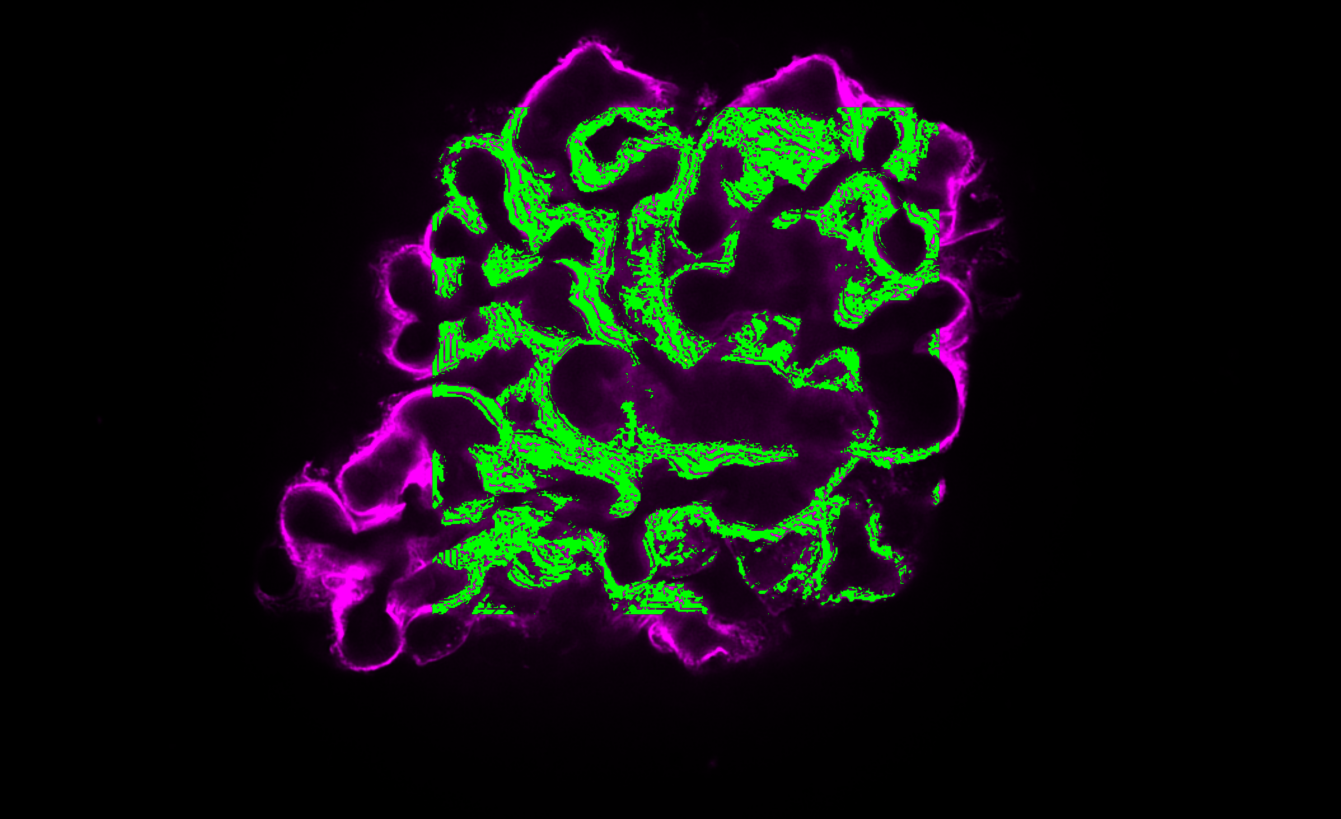

In [ ]:
import skimage.morphology


telp = skimage.morphology.erosion(help)
telp = skimage.morphology.dilation(telp)
telp = skimage.morphology.dilation(telp)
telp = skimage.morphology.dilation(telp)

The same processing on capilarry images seems to work similarly. and gaps are filled in with 1 inital erosion and 3 subsequent dilation operations.

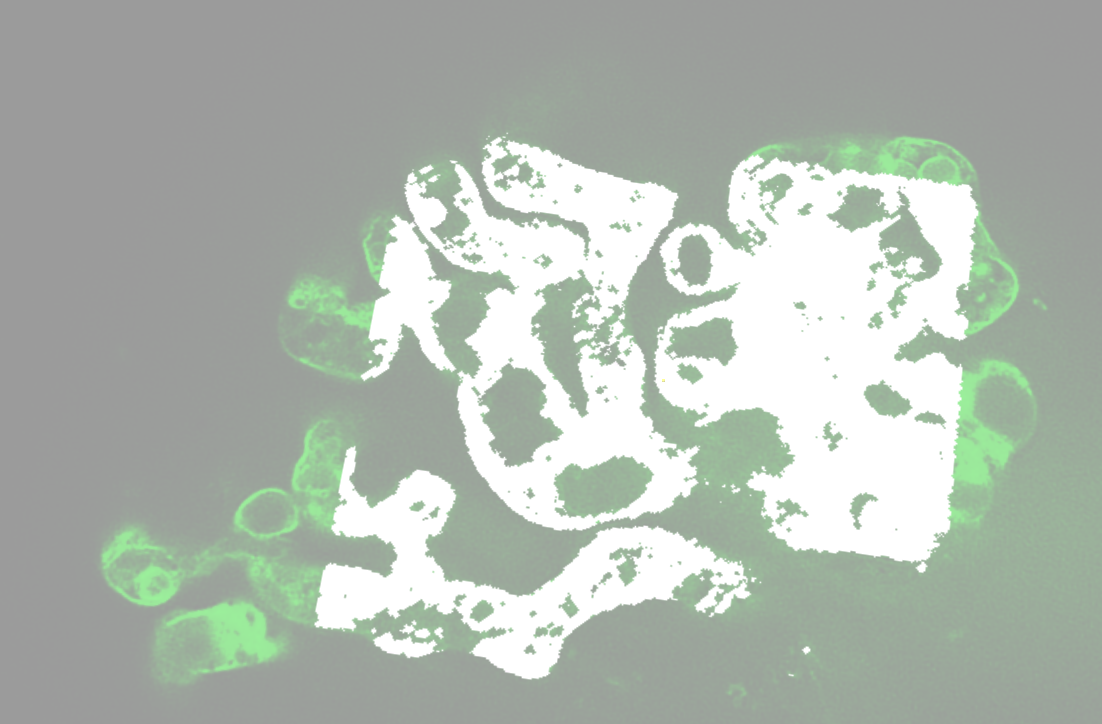

In [ ]:
mw= numpy.min(w[2])
mxw= numpy.max(w[2])
closed= numpy.zeros(numpy.shape(telp))
for n in range (mw,mxw):
    closed[n,:,:] = skimage.morphology.diameter_closing(telp[n,:,:],diameter_threshold=800)

diameter closing opperation in 3d appears to take a long time results from it are poor when sliding in the z axis. Transitionsing this to a 2d iterative approach improved closing function still not a refined and optimal approach but it shows diseirable progress. glom membrane is in orange, the magenta mask is diameter closed region, and the green mask is the inital masking of the capilarries

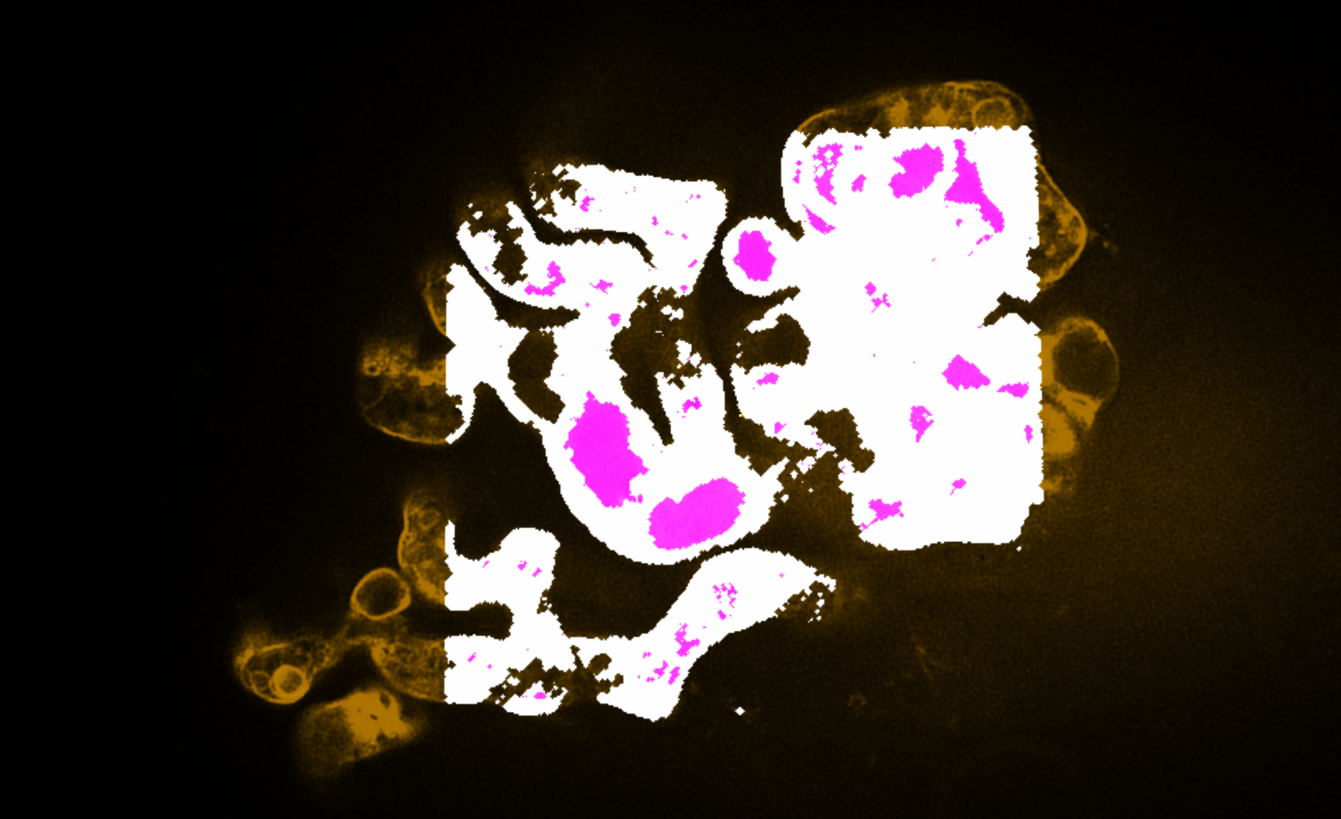
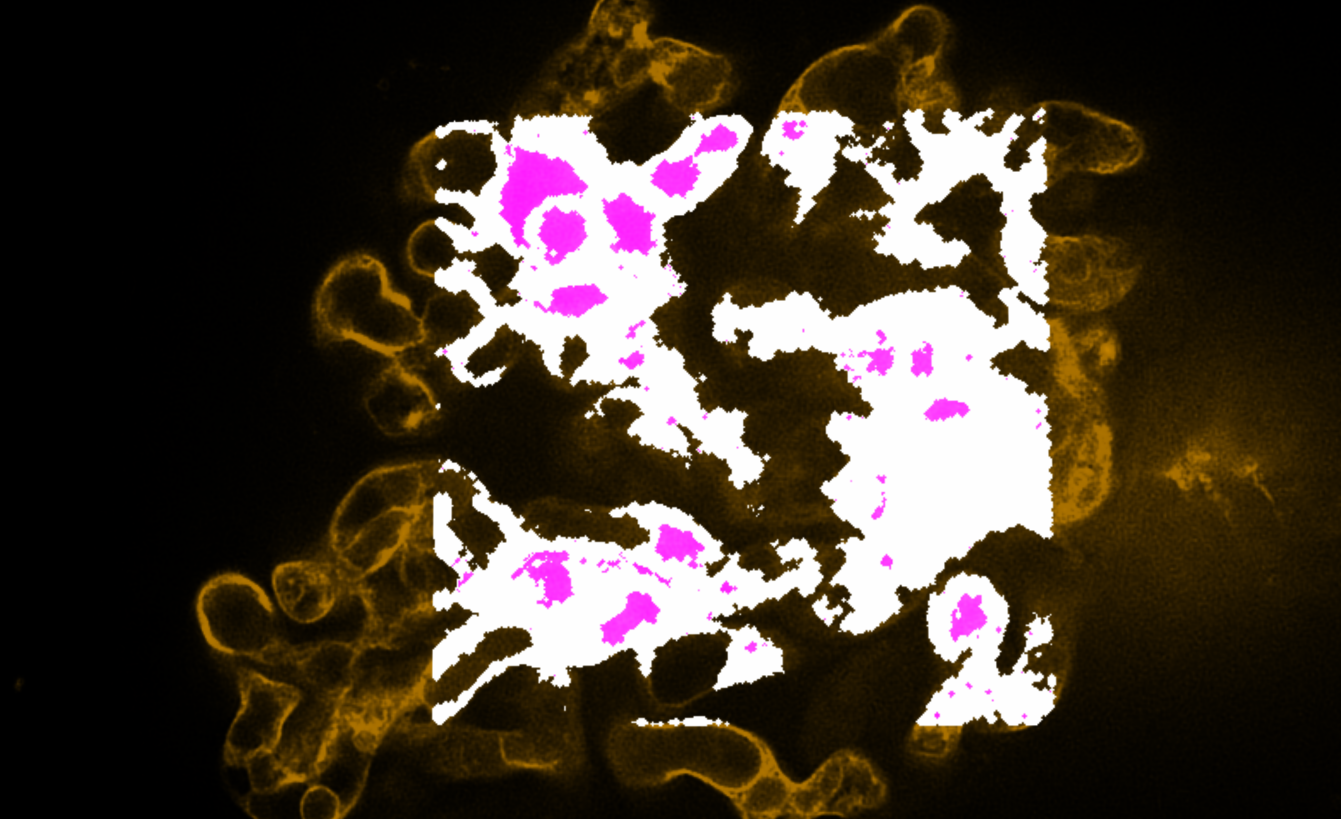

Author: Yoseph  
Date: 20241219

Objective parallel operation for initial for loop in nest loop series

In [ ]:
y=session.models[2].volume.full_matrix().copy()
p= session.models[3].atoms.coords
p=numpy.round(p).astype('int')

matrix=numpy.zeros((numpy.shape(y)))
a=numpy.linspace(p[0,0]-250,p[0,0]+250, 501)
b=numpy.linspace(p[0,1]-250,p[0,1]+250, 5011)
c=numpy.linspace((p[0,2]/1.5)-44,(p[0,2]/1.5)+27, 72)

q=numpy.array(list(itertools.product(*(a,b,c),repeat=1)),dtype='int')
w=numpy.split(q,3,1)
matrix[w[2],w[1],w[0]]=1

In [ ]:
start=time()

welp=matrix*y
welp[welp==0] = numpy.nan

radius=3
cl=numpy.nanmean(welp)*1.15
help= numpy.zeros(numpy.shape(welp))

for h in range(numpy.min(w[2]),numpy.max(w[2])):
    for g in range(numpy.min(w[1]),numpy.max(w[1])):
        for f in range(numpy.min(w[0]),numpy.max(w[0])):
            fl=numpy.int32(numpy.linspace(f-radius,radius+f, 2*radius+1))-1
            gl=numpy.int32(numpy.linspace(g-radius,radius+g, 2*radius+1))-1
            hl=numpy.int32(numpy.linspace(h-radius,radius+h, 2*radius+1))-1
            if numpy.isnan((welp[hl,gl,fl].all()))==False:
                standardD = numpy.nanstd(welp[hl,gl,fl])*0.15
                Thresh= ((numpy.nanmax(welp[hl,gl,fl])-numpy.nanmin(welp[hl,gl,fl]))/2)+standardD
                contrast= (numpy.nanmax(welp[hl,gl,fl])-numpy.nanmin(welp[hl,gl,fl]))
            else:
                help = numpy.nan
            
            if  contrast < cl:
                welp[h,g,f]= 0
            else:
                welp[h,g,f]= welp[h,g,f]
            
            if welp[h,g,f] >= (Thresh):
                help[h,g,f]= 1
            else:
                help[h,g,f]=0

end=time()
print(end - start)

In [ ]:
from numba import njit, prange
from time import time
start=time()

welp=matrix*y
welp[welp==0] = numpy.nan
radius=3
cl=numpy.nanmean(welp)*1.15
@njit(parallel=True, nopython=True)
def FastAT(welp,w,cl):
    n= numpy.max(w[0])-numpy.min(w[0])
    help= numpy.zeros(numpy.shape(welp))
    for h in range(numpy.min(w[2]),numpy.max(w[2])):
        for g in range(numpy.min(w[1]),numpy.max(w[1])):
            for f in prange(n):
                fn=f+numpy.min(w[0])
                fl=(numpy.linspace(fn-radius,radius+fn, 2*radius+1).astype(numpy.int32))-1
                gl=(numpy.linspace(g-radius,radius+g, 2*radius+1).astype(numpy.int32))-1
                hl=(numpy.linspace(h-radius,radius+h, 2*radius+1).astype(numpy.int32))-1
                if numpy.isnan((welp[hl,gl,fl].all()))==False:
                    standardD = numpy.nanstd(welp[hl,gl,fl])*0.15
                    Thresh= ((numpy.nanmax(welp[hl,gl,fl])-numpy.nanmin(welp[hl,gl,fl]))/2)+standardD
                    contrast= (numpy.nanmax(welp[hl,gl,fl])-numpy.nanmin(welp[hl,gl,fl]))
                else:
                    help = -1
                
                if  contrast < cl:
                    welp[h,g,fn]= 0
                else:
                    welp[h,g,fn]= welp[h,g,f]
                
                if welp[h,g,fn] >= (Thresh):
                    help[h,g,fn]= 1
                else:
                    help[h,g,fn]=0
    return (help)

pelp= numpy.array(welp,‘C’, dtype(numpy.float64))
help = FastAT(pelp,w,cl)

end=time()
print(end - start)

numba iterable needs a very specific structure for objects will need to spend work to convert current implementation of function

Multi process method

In [ ]:
from multiprocessing  import Process

start=time()
welp=matrix*y
welp[welp==0] = numpy.nan
radius=3
cl=numpy.nanmean(welp)*1.15
help= numpy.zeros(numpy.shape(welp))
def multipro(f):
    for h in range(numpy.min(w[2]),numpy.max(w[2])):
        for g in range(numpy.min(w[1]),numpy.max(w[1])):
        
            fl=numpy.int32(numpy.linspace(f-radius,radius+f, 2*radius+1))-1
            gl=numpy.int32(numpy.linspace(g-radius,radius+g, 2*radius+1))-1
            hl=numpy.int32(numpy.linspace(h-radius,radius+h, 2*radius+1))-1
            if numpy.isnan((welp[hl,gl,fl].all()))==False:
                standardD = numpy.nanstd(welp[hl,gl,fl])*0.15
                Thresh= ((numpy.nanmax(welp[hl,gl,fl])-numpy.nanmin(welp[hl,gl,fl]))/2)+standardD
                contrast= (numpy.nanmax(welp[hl,gl,fl])-numpy.nanmin(welp[hl,gl,fl]))
            else:
                help = numpy.nan
            
            if  contrast < cl:
                welp[h,g,f]= 0
            else:
                welp[h,g,f]= welp[h,g,f]
            
            if welp[h,g,f] >= (Thresh):
                help[h,g,f]= 1
            else:
                help[h,g,f]=0
    return help[:,:,f]


if __name__ == "__main__": 
    arr=range (numpy.min(w[0]),numpy.max(w[0]))
    for f in range(numpy.min(w[0]),numpy.max(w[0])
        p1 = multiprocessing.Process(target=multipro(f), args=(arr, )
        p1.start()
        p1.join()

end=time()
print(end - start)

In [ ]:
from concurrent.futures import ThreadPoolExecutor 
from time import time

In [ ]:
start=time()
welp=matrix*y
welp[welp==0] = numpy.nan
radius=3
cl=numpy.nanmean(welp)*1.15
help= numpy.zeros(numpy.shape(welp))

h= numpy.int32(numpy.linspace(numpy.min(w[2]),numpy.max(w[2]),numpy.max(w[2])-numpy.min(w[2])+1))
def multipro(h):
    elp=help
    for g in range(numpy.min(w[1]),numpy.max(w[1])):
        for f in range(numpy.min(w[0]),numpy.max(w[0])):
            fl=numpy.int32(numpy.linspace(f-radius,radius+f, 2*radius+1))-1
            gl=numpy.int32(numpy.linspace(g-radius,radius+g, 2*radius+1))-1
            hl=numpy.int32(numpy.linspace(h-radius,radius+h, 2*radius+1))-1
            if numpy.isnan((welp[hl,gl,fl].all()))==False:
                standardD = numpy.nanstd(welp[hl,gl,fl])*0.15
                Thresh= ((numpy.nanmax(welp[hl,gl,fl])-numpy.nanmin(welp[hl,gl,fl]))/2)+standardD
                contrast= (numpy.nanmax(welp[hl,gl,fl])-numpy.nanmin(welp[hl,gl,fl]))
            else:
                elp = numpy.nan
            
            if  contrast < cl:
                welp[h,g,f]= 0
            else:
                welp[h,g,f]= welp[h,g,f]
            
            if welp[h,g,f] >= (Thresh):
                elp[h,g,f]= 1
            else:
                elp[h,g,f]=0
    return elp[h,:,:]

num_threads = 2
with ThreadPoolExecutor(max_workers=num_threads) as executor: 
    # Use the executor to map the function to the array in parallel 
    results = executor.map(multipro, h)
for r in results:
    help[r,:,:]=numpy.array(results)


end=time()
print(end - start)

In [ ]:
start=time()

welp=matrix*y
welp[welp==0] = numpy.nan

radius=3
cl=numpy.nanmean(welp)*1.15
help= numpy.zeros(numpy.shape(welp))

for h in range(numpy.min(w[2]),numpy.max(w[2])):
    for g in range(numpy.min(w[1]),numpy.max(w[1])):
        for f in range(numpy.min(w[0]),numpy.max(w[0])):
            fl=numpy.int32(numpy.linspace(f-radius,radius+f, 2*radius+1))-1
            gl=numpy.int32(numpy.linspace(g-radius,radius+g, 2*radius+1))-1
            hl=numpy.int32(numpy.linspace(h-radius,radius+h, 2*radius+1))-1
            if numpy.isnan((welp[hl,gl,fl].all()))==False:
                standardD = numpy.nanstd(welp[hl,gl,fl])*0.15
                Thresh= ((numpy.nanmax(welp[hl,gl,fl])-numpy.nanmin(welp[hl,gl,fl]))/2)+standardD
                contrast= (numpy.nanmax(welp[hl,gl,fl])-numpy.nanmin(welp[hl,gl,fl]))
            else:
                help = numpy.nan
            
            if  contrast < cl:
                welp[h,g,f]= 0
            else:
                welp[h,g,f]= welp[h,g,f]
            
            if welp[h,g,f] >= (Thresh):
                help[h,g,f]= 1
            else:
                help[h,g,f]=0


end=time()
print(end - start)

Overall the performance of multi threading attempts for the same process failed to be more efficent that the native for loops. this implies that numpy has embeded multi threading functions in scripts.

In [ ]:
start=time()

welp=matrix*y
welp[welp==0] = numpy.nan

radius=3
cl=numpy.nanmean(welp)*1.1
help= numpy.zeros(numpy.shape(welp))

for h in range(numpy.min(w[2]),numpy.max(w[2])):
    for g in range(numpy.min(w[1]),numpy.max(w[1])):
        for f in range(numpy.min(w[0]),numpy.max(w[0])):
            fl=numpy.int32(numpy.linspace(f-radius,radius+f, 2*radius+1))-1
            gl=numpy.int32(numpy.linspace(g-radius,radius+g, 2*radius+1))-1
            hl=numpy.int32(numpy.linspace(h-radius,radius+h, 2*radius+1))-1
            if numpy.isnan((welp[hl,gl,fl].all()))==False:
                standardD = numpy.nanstd(welp[hl,gl,fl])*0.15
                Thresh= ((numpy.nanmax(welp[hl,gl,fl])-numpy.nanmin(welp[hl,gl,fl]))/2)+standardD
                contrast= (numpy.nanmax(welp[hl,gl,fl])-numpy.nanmin(welp[hl,gl,fl]))
            
                if  (contrast > cl) & (welp[h,g,f] >= (Thresh)):
                    help[h,g,f] += 1
                else :
                    help[h,g,f] += 0

end=time()
print(end - start)

In [ ]:
start=time()

welp=matrix*y
welp[welp==0] = numpy.nan

radius=3
cl=numpy.nanmean(welp)*1.1
help= numpy.zeros(numpy.shape(welp))

for h in range(numpy.min(w[2]),numpy.max(w[2])):
    for g in range(numpy.min(w[1]),numpy.max(w[1])):
        for f in range(numpy.min(w[0]),numpy.max(w[0])):
            fl=numpy.int32(numpy.linspace(f-radius,radius+f, 2*radius+1))-1
            gl=numpy.int32(numpy.linspace(g-radius,radius+g, 2*radius+1))-1
            hl=numpy.int32(numpy.linspace(h-radius,radius+h, 2*radius+1))-1
            if numpy.isnan((welp[hl,gl,fl].all()))==False:
                standardD = numpy.nanstd(welp[hl,gl,fl])*0.15
                Thresh= ((numpy.nanmax(welp[hl,gl,fl])-numpy.nanmin(welp[hl,gl,fl]))/2)+standardD
                contrast= (numpy.nanmax(welp[hl,gl,fl])-numpy.nanmin(welp[hl,gl,fl]))
            
                if  (contrast > cl) & (welp[h,g,f] >= (Thresh)):
                    help[h,g,f] += 1
                else :
                    help[h,g,f] += 0

end=time()
print(end - start)

3.6 hour reconstruction:



In [ ]:

welp=matrix*y
welp=scipy.ndimage.gaussian_filter(welp,sigma=1)
welp[welp==0] = numpy.nan

radius=2
cl=numpy.nanmean(welp)*1.15
help= numpy.zeros(numpy.shape(welp))
for h in range(numpy.min(w[2]),numpy.max(w[2])):
    for g in range(numpy.min(w[1]),numpy.max(w[1])):
        for f in range(numpy.min(w[0]),numpy.max(w[0])):
            fl=numpy.int32(numpy.linspace(f-radius,radius+f, 2*radius+1))-1
            gl=numpy.int32(numpy.linspace(g-radius,radius+g, 2*radius+1))-1
            hl=numpy.int32(numpy.linspace(h-radius,radius+h, 2*radius+1))-1
            if numpy.isnan((welp[hl,gl,fl].all()))==False:
                standardD = numpy.nanstd(welp[hl,gl,fl])*0.15
                Thresh= ((numpy.nanmax(welp[hl,gl,fl])-numpy.nanmin(welp[hl,gl,fl]))/2)+standardD
                contrast= (numpy.nanmax(welp[hl,gl,fl])-numpy.nanmin(welp[hl,gl,fl]))
            else:
                help = numpy.nan

            if  contrast < cl:
                welp[h,g,f]= 0
            else:
                welp[h,g,f]= welp[h,g,f]

            if welp[h,g,f] >= (Thresh):
                help[h,g,f]= 1
            else:
                help[h,g,f]=0

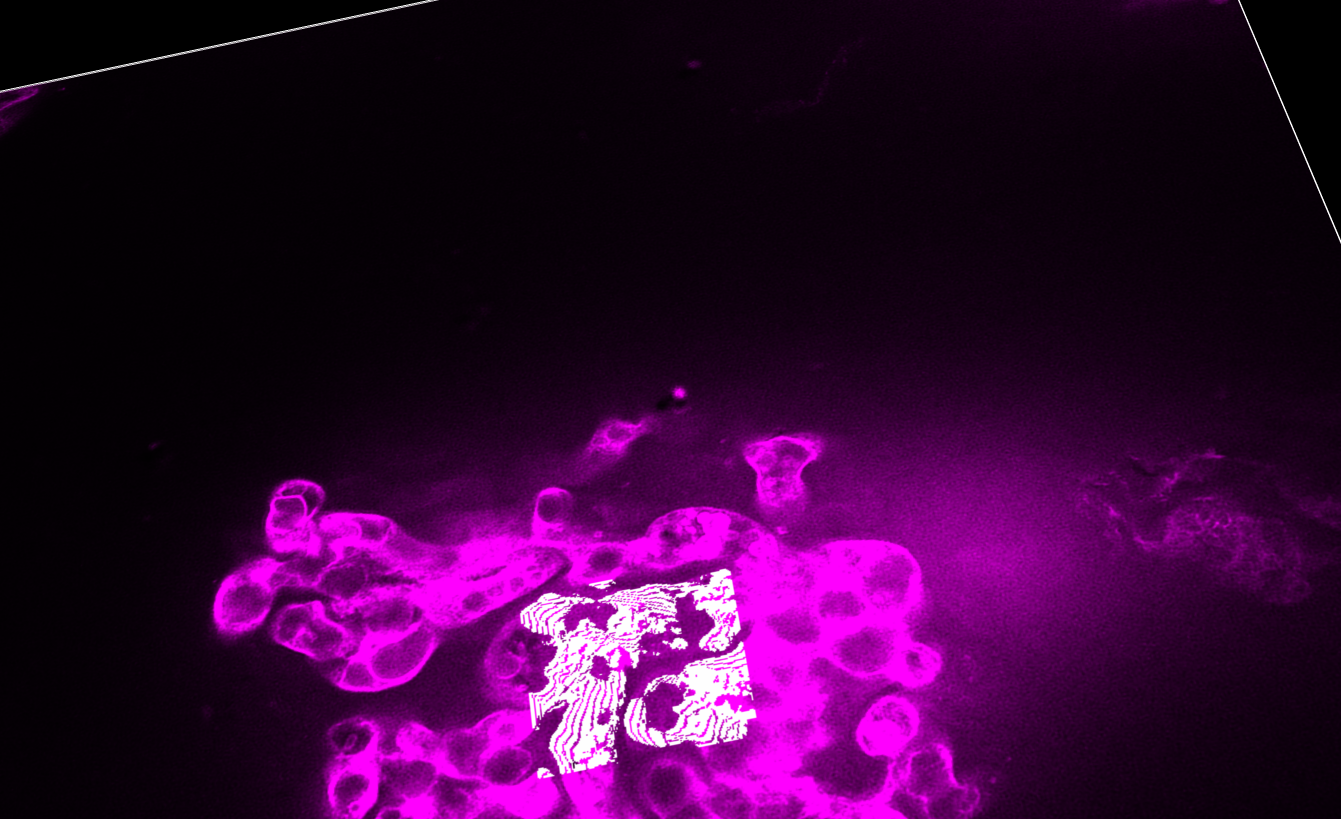

In [ ]:
from scipy import spatial
from numpy import flip as fp

s=time()
y=session.models[2].volume.full_matrix().copy()
p= session.models[3].atoms.coords
p=numpy.round(p).astype('int')

matrix=numpy.zeros((numpy.shape(y)))

a=numpy.linspace(p[0,0]-40,p[0,0]+40, 81)
b=numpy.linspace(p[0,1]-40,p[0,1]+40, 81)
c=numpy.linspace((p[0,2]/1.5)-44,(p[0,2]/1.5)+27, 72)

q=numpy.array(list(itertools.product(*(a,b,c),repeat=1)),dtype='int')
w=numpy.split(q,3,1)
matrix[w[2],w[1],w[0]]=1

cl=numpy.nanmean(y[w[2],w[1],w[0]])*1.15

qtree=scipy.spatial.KDTree(q)
index = qtree.query_ball_point(q, r=3, workers=-1)

"""generates a single 1d array with array 1d index"""

help=numpy.zeros(numpy.shape(y))

for ind in range (0,numpy.shape(index)[0]):
    tz,ty,tx = numpy.split(fp(q[index[ind]],axis=1),3,1)
    
    x,yy,z = q[ind]
    standardD = numpy.nanstd(y[tz,ty,tx])*0.15 
    Thresh= ((numpy.nanmax(y[tz,ty,tx])-numpy.nanmin(y[tz,ty,tx]))/2)+standardD
    contrast= (numpy.nanmax(y[tz,ty,tx])-numpy.nanmin(y[tz,ty,tx])) 

    if (contrast > cl) & (y[z,yy,x] >= Thresh):
        help[z,yy,x] = 1


e=time()
print(e-s)

runs in ~59 sec original script same size ran in ~135 sec

In [ ]:
s=time()
y=session.models[2].volume.full_matrix().copy()
p= session.models[3].atoms.coords

def goop(p):
    n= 50
    p=numpy.round(p).astype('int')

    a=numpy.linspace(p[0,0]-n,p[0,0]+n, n*2)
    b=numpy.linspace(p[0,1]-n,p[0,1]+n, n*2)
    c=numpy.linspace((p[0,2]/1.5)-10,(p[0,2]/1.5)+10, 31)

    q=numpy.array(list(itertools.product(*(a,b,c),repeat=1)),dtype='int')
    w=numpy.split(q,3,1)

    cl=numpy.nanmean(y[w[2],w[1],w[0]])*1.15
    return q, cl

q,cl = goop(p=p)
qtree=scipy.spatial.KDTree(q)
index = qtree.query_ball_point(q, r=3, workers=-1)

"""generates a single 1d array with array 1d index"""

def loop_ROI(q,index):
    help=numpy.zeros(numpy.shape(y))
    for ind in range (0,numpy.shape(index)[0]):
        tz,ty,tx = numpy.split(numpy.flip(q[index[ind]],axis=1),3,1)
        
        x,yy,z = q[ind]
        standardD = numpy.nanstd(y[tz,ty,tx])*0.15 
        Thresh= ((numpy.nanmax(y[tz,ty,tx])-numpy.nanmin(y[tz,ty,tx]))/2)+standardD
        contrast= (numpy.nanmax(y[tz,ty,tx])-numpy.nanmin(y[tz,ty,tx])) 

        help[z,yy,x] = (contrast > cl) * (y[z,yy,x] >= Thresh)
    return help

help = loop_ROI(q = q, index = index)

e=time()
print(e-s)

In [ ]:
mask=ArrayGridData(matrix,step=(1,1,1.5))
volume_from_grid_data(mask,session)

implementing local variable usage as opposed to global varibles (implimenting iterables in functions) increased performance (prior is ~59 current is ~52.3 sec)

In [ ]:
###welp = [(contrast[ind] > cl) & (y[(q[qtree.indices[ind]][2],q[qtree.indices[ind]][1],q[qtree.indices[ind]][0])] >= (Thresh[ind])) for ind in range (0,numpy.shape(index)[0])]

In [ ]:
tz,ty,tx = [numpy.split(fp(q[index[ind]],axis=1),3,1) for ind in range range (0,numpy.shape(index)[0])]


movie record;
view 1;
wait 1;
view 2 36;
wait 36;
view 3 36;
wait 36;
view 1 36;
wait 36;
crossfade 24;
volume #2 style mesh;
wait 24;
view 2 36;
wait 36;
view 3 36;
wait 36;
view 1 36;
wait 36;
crossfade 24;
volume #2 style surface;
wait 24;

In [ ]:
'''sauvola method'''
s=time()
y=session.models[2].volume.full_matrix().copy()
p= session.models[3].atoms.coords

def goop(p):
    n= 50
    p=numpy.round(p).astype('int')

    a=numpy.linspace(p[0,0]-n,p[0,0]+n, n*2)
    b=numpy.linspace(p[0,1]-n,p[0,1]+n, n*2)
    c=numpy.linspace((p[0,2]/1.5)-15,(p[0,2]/1.5)+15, 31)

    q=numpy.array(list(itertools.product(*(a,b,c),repeat=1)),dtype='int')
    w=numpy.split(q,3,1)

    cl=numpy.nanmean(y[w[2],w[1],w[0]])*1.15
    return q, cl

q,cl = goop(p=p)
qtree=scipy.spatial.KDTree(q)
index = qtree.query_ball_point(q, r=3, workers=-1)

"""generates a single 1d array with array 1d index"""

def loop_ROI(q,index):
    help=numpy.zeros(numpy.shape(y))
    for ind in range (0,numpy.shape(index)[0]):
        tz,ty,tx = numpy.split(numpy.flip(q[index[ind]],axis=1),3,1)
        
        x,yy,z = q[ind]
        standardD = numpy.nanstd(y[tz,ty,tx])
        mean=numpy.nanmean(y[tz,ty,tx])
        """Thresh= ((numpy.nanmax(y[tz,ty,tx])-numpy.nanmin(y[tz,ty,tx]))/2)+standardD
        contrast= (numpy.nanmax(y[tz,ty,tx])-numpy.nanmin(y[tz,ty,tx])) """
        Vola= mean * (1+ 0.5 *((standardD/(2^16))-1))
        help[z,yy,x] = (y[z,yy,x] >= Vola)
    return help

help = loop_ROI(q = q, index = index)

e=time()
print(e-s)

Sauvola method fails to find membrane edges in interlaced regions

In [ ]:
(Odd bernsen method of local thresholding with weighted min/max thresholding gate)
s=time()
y=session.models[2].volume.full_matrix().copy()
p= session.models[3].atoms.coords

def goop(p):
    n= 50
    p=numpy.round(p).astype('int')

    a=numpy.linspace(p[0,0]-n,p[0,0]+n, n*2)
    b=numpy.linspace(p[0,1]-n,p[0,1]+n, n*2)
    c=numpy.linspace((p[0,2]/1.5)-10,(p[0,2]/1.5)+15, 36)

    q=numpy.array(list(itertools.product(*(a,b,c),repeat=1)),dtype='int')
    w=numpy.split(q,3,1)

    cl=numpy.nanmean(y[w[2],w[1],w[0]])*1.15
    return q, cl

q,cl = goop(p=p)
qtree=scipy.spatial.KDTree(q)
index = qtree.query_ball_point(q, r=2, workers=-1)

"""generates a single 1d array with array 1d index"""

def loop_ROI(q,index):
    help=numpy.zeros(numpy.shape(y))
    for ind in range (0,numpy.shape(index)[0]):
        tz,ty,tx = numpy.split(numpy.flip(q[index[ind]],axis=1),3,1)

        x,yy,z = q[ind]
        standardD = numpy.nanstd(y[tz,ty,tx])*0.15 
        Thresh= (0.7*(numpy.nanmax(y[tz,ty,tx])+0.3*numpy.nanmin(y[tz,ty,tx]))/2)+standardD
        contrast= (numpy.nanmax(y[tz,ty,tx])-numpy.nanmin(y[tz,ty,tx])) - standardD

        help[z,yy,x] = (contrast > cl) * (y[z,yy,x] >= Thresh)
    return help

help = loop_ROI(q = q, index = index)

e=time()
print(e-s)

In [ ]:
s=time()
y=session.models[2].volume.full_matrix().copy()
p= session.models[3].atoms.coords

def goop(p):
    n= 50
    p=numpy.round(p).astype('int')

    a=numpy.linspace(p[0,0]-n,p[0,0]+n, n*2)
    b=numpy.linspace(p[0,1]-n,p[0,1]+n, n*2)
    c=numpy.linspace((p[0,2]/1.5)-10,(p[0,2]/1.5)+15, 36)

    q=numpy.array(list(itertools.product(*(a,b,c),repeat=1)),dtype='int')
    w=numpy.split(q,3,1)

    cl=numpy.nanmean(y[w[2],w[1],w[0]])*1.15
    return q, cl

q,cl = goop(p=p)
qtree=scipy.spatial.KDTree(q)
index = qtree.query_ball_point(q, r=2, workers=-1)

"""generates a single 1d array with array 1d index"""

def loop_ROI(q,index):
    help=numpy.zeros(numpy.shape(y))
    for ind in range (0,numpy.shape(index)[0]):
        tz,ty,tx = numpy.split(numpy.flip(q[index[ind]],axis=1),3,1)

        x,yy,z = q[ind]
        standardD = numpy.nanstd(y[tz,ty,tx])*0.15 
        Thresh= (0.7*(numpy.nanmax(y[tz,ty,tx])+0.3*numpy.nanmin(y[tz,ty,tx]))/2)+standardD
        contrast= (numpy.nanmax(y[tz,ty,tx])-numpy.nanmin(y[tz,ty,tx])) - standardD

        help[z,yy,x] = (contrast > cl) * (y[z,yy,x] >= Thresh)
    return help

help = loop_ROI(q = q, index = index)

e=time()
print(e-s)

In [ ]:
s=time()
y=session.models[3].volume.full_matrix().copy()
p= session.models[4].atoms.coords
bg=450
def goop(p):
    n= 75
    p=numpy.round(p).astype('int')

    a=numpy.linspace(p[0,0]-n,p[0,0]+n, n*2)
    b=numpy.linspace(p[0,1]-n,p[0,1]+n, n*2)
    c=numpy.linspace((p[0,2]/1.5)-15,(p[0,2]/1.5)+15, 31)

    q=numpy.array(list(itertools.product(*(a,b,c),repeat=1)),dtype='int')
    w=numpy.split(q,3,1)

    cl=numpy.nanmean(y[w[2],w[1],w[0]])*1.15
    return q, cl

q,cl = goop(p=p)
qtree=scipy.spatial.KDTree(q)
index = qtree.query_ball_point(q, r=3, workers=-1)

"""generates a single 1d array with array 1d index"""
'''Smoothing to keep a nice surface'''
tl=y-(numpy.zeros(numpy.shape(y))+bg)
mask = (tl>0)
l=scipy.ndimage.gaussian_filter(tl,sigma=.3,truncate=8)*mask
def loop_ROI(q,index,l,mask):
    help=numpy.zeros(numpy.shape(y))
    telp=numpy.zeros(numpy.shape(y))
    for ind in range (0,numpy.shape(index)[0]):
        tz,ty,tx = numpy.split(numpy.flip(q[index[ind]],axis=1),3,1)

        x,yy,z = q[ind]
        standardD = numpy.nanstd(l[tz,ty,tx])*0.15 
        Thresh= ((numpy.nanmax(l[tz,ty,tx])-numpy.nanmin(l[tz,ty,tx]))/2)+standardD
        contrast= (numpy.nanmax(l[tz,ty,tx])-numpy.nanmin(l[tz,ty,tx])) 

        help[z,yy,x] = (contrast < cl) * (l[z,yy,x] >= Thresh)
        telp[z,yy,x] = help[z,yy,x]*mask[z,yy,x]
    return telp

telp = loop_ROI(q = q, index = index,l=l,mask=mask)

e=time()
print(e-s)

In [ ]:
mask=ArrayGridData(telp,step=(1,1,1.5))
volume_from_grid_data(mask,session)

Most recent implimentation of the bersen method yeils good local thresholding and cappilarry reconstruction in the z axis
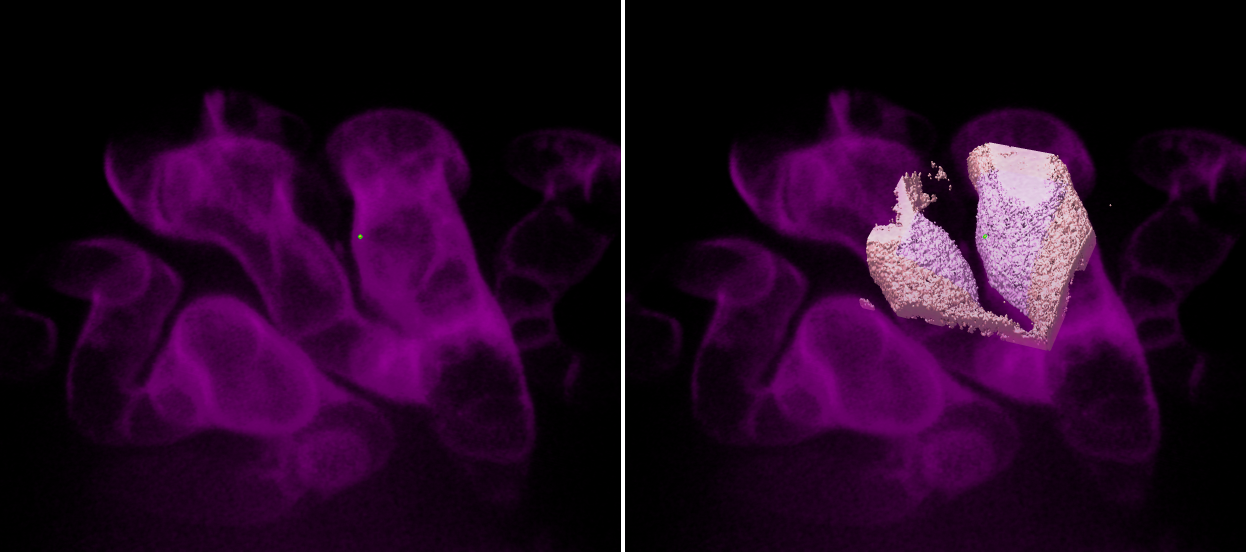

Modifiying to move into a automatick sliding box thresholding for full ROI

In [ ]:
s=time()
y=session.models[2].volume.full_matrix().copy()
iu= session.models[3].atoms.coords
bg=450

def goop(p):
    n= 10

    p=numpy.round(p).astype('int')

    a=numpy.linspace(p[0]-n,p[0]+n, n*2)
    b=numpy.linspace(p[1]-n,p[1]+n, n*2)
    c=numpy.linspace(0,(numpy.shape(y))[0]-1, (numpy.shape(y)[0])-1)

    q=numpy.array(list(itertools.product(*(a,b,c),repeat=1)),dtype='int')
    w=numpy.split(q,3,1)

    cl=numpy.nanmean(y[w[2],w[1],w[0]])*1.5
    return q, cl

def loop_ROI(q,index,l,mask):
    help=numpy.zeros(numpy.shape(y))
    telp=numpy.zeros(numpy.shape(y))
    for ind in range (0,numpy.shape(index)[0]):
        tz,ty,tx = numpy.split(numpy.flip(q[index[ind]],axis=1),3,1)

        x,yy,z = q[ind]
        standardD = numpy.nanstd(l[tz,ty,tx])*0.15 
        Thresh= ((numpy.nanmax(l[tz,ty,tx])-numpy.nanmin(l[tz,ty,tx]))/2)+standardD
        contrast= (numpy.nanmax(l[tz,ty,tx])-numpy.nanmin(l[tz,ty,tx])) 

        help[z,yy,x] = (contrast < cl) * (l[z,yy,x] >= Thresh)
        telp[z,yy,x] = help[z,yy,x]*mask[z,yy,x]
    return telp

elp=numpy.zeros(numpy.shape(y))
for iu in range (0,numpy.shape(p)[0]):
    q,cl = goop(p=p[iu,:])
    qtree=scipy.spatial.KDTree(q)
    index = qtree.query_ball_point(q, r=3, workers=-1)
    """generates a single 1d array with array 1d index"""

    tl=y-(numpy.zeros(numpy.shape(y))+bg)
    mask = (tl>0)

    '''Smoothing to keep a nice surface'''

    l=scipy.ndimage.gaussian_filter(tl,sigma=.3,truncate=8)*mask
    telp = loop_ROI(q = q, index = index,l=l,mask=mask)
    
    elp = (telp+elp)>0
e=time()
print(e-s)

In [ ]:
s=time()
y=session.models[2].volume.full_matrix().copy()
p= session.models[3].atoms.coords
bg=450

def goop(p):
    n= 50

    p=numpy.round(p).astype('int')

    a=numpy.linspace(p[0]-n,p[0]+n, n*2)
    b=numpy.linspace(p[1]-n,p[1]+n, n*2)
    c=numpy.linspace(0,(numpy.shape(y))[0]-1, (numpy.shape(y)[0]-1))

    q=numpy.array(list(itertools.product(*(a,b,c),repeat=1)),dtype='int')
    w=numpy.split(q,3,1)

    cl=numpy.nanmean(y[w[2],w[1],w[0]])*1.5
    return q, cl

def loop_ROI(q,index,l,mask):
    help=numpy.zeros(numpy.shape(y))
    telp=numpy.zeros(numpy.shape(y))
    for ind in range (0,numpy.shape(index)[0]):
        tz,ty,tx = numpy.split(numpy.flip(q[index[ind]],axis=1),3,1)

        x,yy,z = q[ind]
        standardD = numpy.nanstd(l[tz,ty,tx])*0.15
        Thresh= ((numpy.nanmax(l[tz,ty,tx].8)-numpy.nanmin(l[tz,ty,tx]))/2)+standardD
        contrast= (numpy.nanmax(l[tz,ty,tx])-numpy.nanmin(l[tz,ty,tx])) 

        help[z,yy,x] = (contrast < cl) * (l[z,yy,x] >= Thresh)
        telp[z,yy,x] = help[z,yy,x]*mask[z,yy,x]
    return telp

elp=numpy.zeros(numpy.shape(y))
for iu in range (0,numpy.shape(p)[0]):
    q,cl = goop(p=p[iu,:])
    qtree=scipy.spatial.KDTree(q)
    index = qtree.query_ball_point(q, r=3, workers=-1)
    """generates a single 1d array with array 1d index"""

    tl=y-(numpy.zeros(numpy.shape(y))+bg)
    mask = (tl>0)

    '''Smoothing to keep a nice surface'''

    li=scipy.ndimage.gaussian_filter(tl,sigma=.3,truncate=6)*mask
    l=li*(li>((numpy.nanstd(li))+(numpy.nanquantile(li,q=0.85))))   
    telp = loop_ROI(q = q, index = index,l=l,mask=mask)

    elp = (telp+elp)>0
e=time()
print(e-s)

In [ ]:
s=time()
y=session.models[2].volume.full_matrix().copy()
p= session.models[3].atoms.coords
bg=450

def goop(p):
    n= 60

    p=numpy.round(p).astype('int')

    a=numpy.linspace(p[0]-n,p[0]+n, n*2)
    b=numpy.linspace(p[1]-n,p[1]+n, n*2)
    c=numpy.linspace(0,(numpy.shape(y))[0]-1, (numpy.shape(y)[0]-1))

    q=numpy.array(list(itertools.product(*(a,b,c),repeat=1)),dtype='int')
    w=numpy.split(q,3,1)

    cl=numpy.nanmean(l[w[2],w[1],w[0]])*.2
    return q, cl

def loop_ROI(q,index,l,mask):
    help=numpy.zeros(numpy.shape(y))
    telp=numpy.zeros(numpy.shape(y))
    for ind in range (0,numpy.shape(index)[0]):
        tz,ty,tx = numpy.split(numpy.flip(q[index[ind]],axis=1),3,1)

        x,yy,z = q[ind]
        if numpy.all(numpy.isnan(l[tz,ty,tx]))==0:
            standardD = numpy.nanstd(l[tz,ty,tx])*0.15
            Thresh= ((numpy.nanmax(l[tz,ty,tx])-numpy.nanmin(l[tz,ty,tx])*1.15)/2)+standardD
            contrast= (numpy.nanmax(l[tz,ty,tx])-numpy.nanmin(l[tz,ty,tx])) 

            help[z,yy,x] = (contrast >= cl) * (l[z,yy,x] >= Thresh)
            telp[z,yy,x] = help[z,yy,x]*mask[z,yy,x]
        else:
            telp[z,yy,x]=0
    return telp

elp=numpy.zeros(numpy.shape(y))
tl=y-(numpy.zeros(numpy.shape(y))+bg)
mask = (tl>0)
li=scipy.ndimage.gaussian_filter(tl,sigma=.4,truncate=5)*mask
lp=li*(li>((numpy.nanstd(li))+(numpy.nanquantile(li,q=0.85))))   
l=lp
l[l==0]=numpy.nan
for iu in range (0,numpy.shape(p)[0]):
    q,cl = goop(p=p[iu,:])
    qtree=scipy.spatial.KDTree(q)
    index = qtree.query_ball_point(q, r=3, workers=-1)
    """generates a single 1d array with array 1d index"""

    '''Smoothing to keep a nice surface'''

    
    telp = loop_ROI(q = q, index = index,l=l,mask=mask)

    elp = (telp+elp)>0
e=time()
print(e-s)

open C:\Users\LoydY\Documents\917_006\006_decon_capillaries.tif format images

New Workstation 2025

In [ ]:
y=session.models[2].volume.full_matrix().copy()
p= session.models[3].atoms.coords
p=numpy.round(p).astype('int')

matrix=numpy.zeros((numpy.shape(y)))
a=numpy.linspace(p[0,0]-300,p[0,0]+300, 601)
b=numpy.linspace(p[0,1]-300,p[0,1]+300, 601)
c=numpy.linspace((p[0,2]/2)-44,(p[0,2]/2)+35, 80)

q=numpy.array(list(itertools.product(*(a,b,c),repeat=1)),dtype='int')
w=numpy.split(q,3,1)
matrix[w[2],w[1],w[0]]=1
mask=ArrayGridData(matrix,step=(1,1,2))
volume_from_grid_data(mask,session)

In [ ]:
s=time()

y=session.models[2].volume.full_matrix().copy()
p= session.models[3].atoms.coords
p=numpy.round(p).astype('int')

def goop(p):
    n= 50

    p=numpy.round(p).astype('int')

    a=numpy.linspace(p[0,0]-n,p[0,0]+n, n*2)
    b=numpy.linspace(p[0,1]-n,p[0,1]+n, n*2)
    c=numpy.linspace((p[0,2]/2)-14,(p[0,2]/2)+15, 20)

    q=numpy.array(list(itertools.product(*(a,b,c),repeat=1)),dtype='int')
    w=numpy.split(q,3,1)

    cl=numpy.nanmean(y[w[2],w[1],w[0]])*1.15
    return q, cl

q,cl = goop(p=p)
qtree=scipy.spatial.KDTree(q)
index = qtree.query_ball_point(q, r=3, workers=-1)

"""generates a single 1d array with array 1d index"""

def loop_ROI(q,index):
    help=numpy.zeros(numpy.shape(y))
    for ind in range (0,numpy.shape(index)[0]):
        tz,ty,tx = numpy.split(numpy.flip(q[index[ind]],axis=1),3,1)
        
        x,yy,z = q[ind]
        standardD = numpy.nanstd(y[tz,ty,tx])*0.15 
        Thresh= ((numpy.nanmax(y[tz,ty,tx])-numpy.nanmin(y[tz,ty,tx]))/2)+standardD
        contrast= (numpy.nanmax(y[tz,ty,tx])-numpy.nanmin(y[tz,ty,tx])) 

        help[z,yy,x] = (contrast > cl) * (y[z,yy,x] >= Thresh)
    return help

help = loop_ROI(q = q, index = index)

e=time()
print(e-s)

In [ ]:
s=time()
y=session.models[3].volume.full_matrix().copy()
p= session.models[4].atoms.coords
bg=4000
def goop(p):
    n= 50
    p=numpy.round(p).astype('int')

    a=numpy.linspace(p[0,0]-n,p[0,0]+n, n*2)
    b=numpy.linspace(p[0,1]-n,p[0,1]+n, n*2)
    c=numpy.linspace((p[0,2]/1.5)-15,(p[0,2]/1.5)+15, 31)

    q=numpy.array(list(itertools.product(*(a,b,c),repeat=1)),dtype='int')
    w=numpy.split(q,3,1)

    cl=numpy.nanmean(y[w[2],w[1],w[0]])*1.15
    return q, cl

q,cl = goop(p=p)
qtree=scipy.spatial.KDTree(q)
index = qtree.query_ball_point(q, r=2, workers=-1)

"""generates a single 1d array with array 1d index"""
'''Smoothing to keep a nice surface'''
tl=y-(numpy.zeros(numpy.shape(y))+bg)
mask = (tl>0)
l=scipy.ndimage.gaussian_filter(tl,sigma=.3,truncate=8)*mask
def loop_ROI(q,index,l,mask):
    help=numpy.zeros(numpy.shape(y))
    telp=numpy.zeros(numpy.shape(y))
    for ind in range (0,numpy.shape(index)[0]):
        tz,ty,tx = numpy.split(numpy.flip(q[index[ind]],axis=1),3,1)

        x,yy,z = q[ind]
        standardD = numpy.nanstd(l[tz,ty,tx])*0.15 
        Thresh= ((numpy.nanmax(l[tz,ty,tx])-numpy.nanmin(l[tz,ty,tx]))/2)+standardD
        contrast= (numpy.nanmax(l[tz,ty,tx])-numpy.nanmin(l[tz,ty,tx])) 

        help[z,yy,x] = (contrast < cl) * (l[z,yy,x] >= Thresh)
        telp[z,yy,x] = help[z,yy,x]*mask[z,yy,x]
    return telp

telp = loop_ROI(q = q, index = index,l=l,mask=mask)

e=time()
print(e-s)

This function of the code worked on a small subsection to define FP


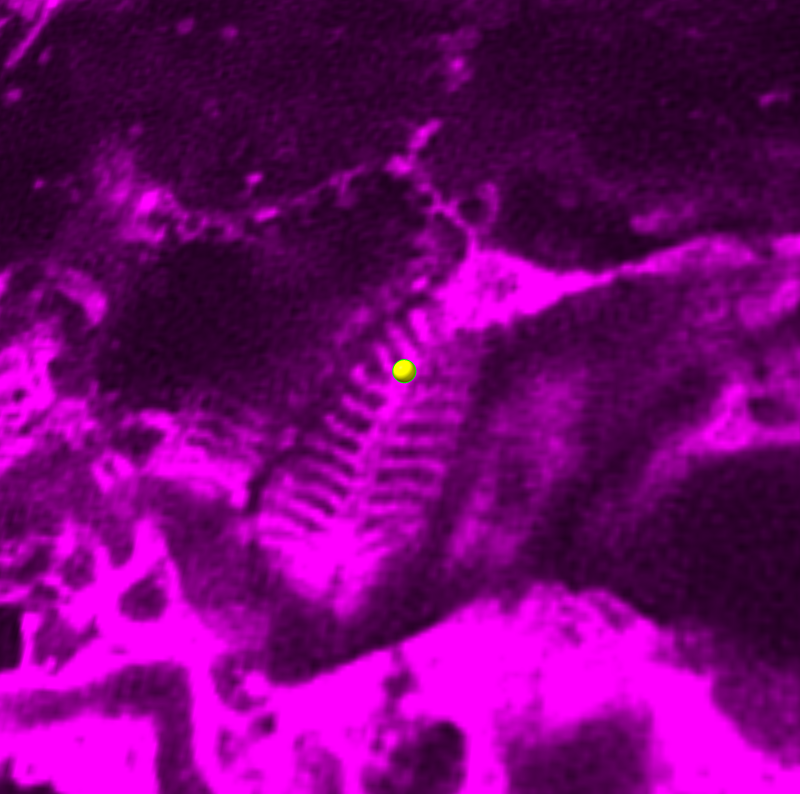
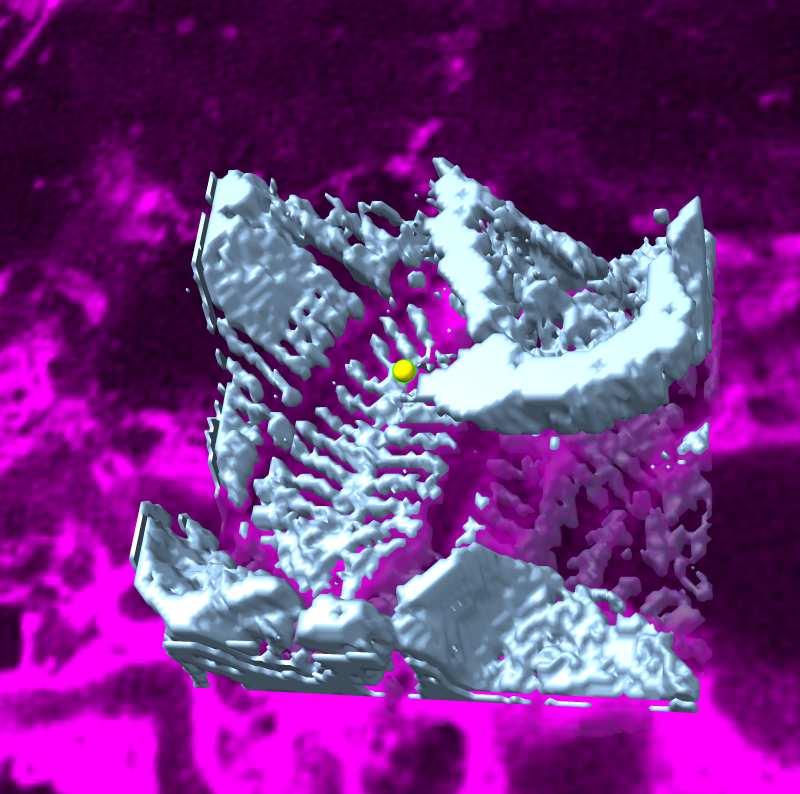

In [ ]:
s=time()
y=session.models[2].volume.full_matrix().copy()
p= session.models[3].atoms.coords
bg=4500
def goop(p):
    n= 100
    p=numpy.round(p).astype('int')

    a=numpy.linspace(p[0,0]-n,p[0,0]+n, n*2)
    b=numpy.linspace(p[0,1]-n,p[0,1]+n, n*2)
    c=numpy.linspace((p[0,2]/2)-40,(p[0,2]/2)+10, 51)

    q=numpy.array(list(itertools.product(*(a,b,c),repeat=1)),dtype='int')
    w=numpy.split(q,3,1)

    cl=numpy.nanmean(y[w[2],w[1],w[0]])
    return q, cl

q,cl = goop(p=p)
qtree=scipy.spatial.KDTree(q)
index = qtree.query_ball_point(q, r=5, workers=-1)

"""generates a single 1d array with array 1d index"""
'''Smoothing to keep a nice surface'''
tl=y-(numpy.zeros(numpy.shape(y))+bg)
mask = (tl>0)
l=scipy.ndimage.gaussian_filter(tl,sigma=.3,truncate=1)*mask
def loop_ROI(q,index,l,mask):
    help=numpy.zeros(numpy.shape(y))
    telp=numpy.zeros(numpy.shape(y))
    for ind in range (0,numpy.shape(index)[0]):
        tz,ty,tx = numpy.split(numpy.flip(q[index[ind]],axis=1),3,1)

        x,yy,z = q[ind]
        standardD = numpy.nanstd(l[tz,ty,tx])*0.35 
        Thresh= (((numpy.nanmax(l[tz,ty,tx])-numpy.nanmin(l[tz,ty,tx])*.75))/2)-standardD
        contrast= (numpy.nanmax(l[tz,ty,tx])-numpy.nanmin(l[tz,ty,tx])) 

        help[z,yy,x] = (contrast > (0.65*cl)) * (l[z,yy,x] >= Thresh*.9)
        telp[z,yy,x] = help[z,yy,x]*mask[z,yy,x]
    return telp

telp = loop_ROI(q = q, index = index,l=l,mask=mask)

e=time()
print(e-s)

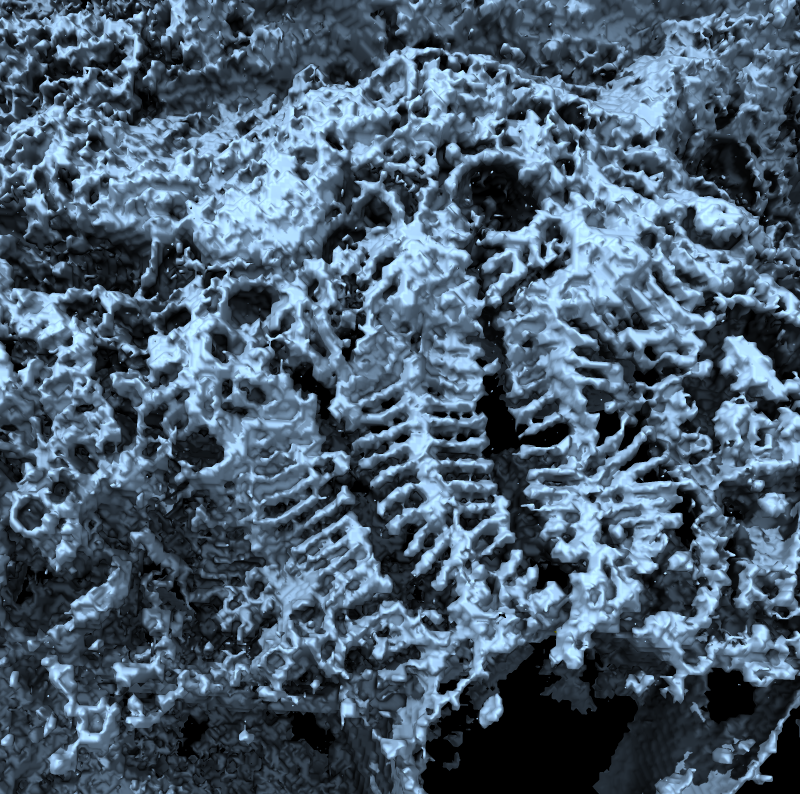

In [ ]:
s=time()
y=session.models[2].volume.full_matrix().copy()
p= session.models[3].atoms.coords
bg=4500
def goop(p):
    n= 200
    p=numpy.round(p).astype('int')

    a=numpy.linspace(p[0,0]-n,p[0,0]+n, n*2)
    b=numpy.linspace(p[0,1]-n,p[0,1]+n, n*2)
    c=numpy.linspace((p[0,2]/2)-40,(p[0,2]/2)+15, 56)

    q=numpy.array(list(itertools.product(*(a,b,c),repeat=1)),dtype='int')
    w=numpy.split(q,3,1)

    cl=numpy.nanmean(y[w[2],w[1],w[0]])
    return q, cl

q,cl = goop(p=p)
qtree=scipy.spatial.KDTree(q)
index = qtree.query_ball_point(q, r=3, workers=-1)

"""generates a single 1d array with array 1d index"""
'''Smoothing to keep a nice surface'''
tl=y-(numpy.zeros(numpy.shape(y))+bg)
mask = (tl>0)
l=scipy.ndimage.gaussian_filter(tl,sigma=.3,truncate=1)*mask
def loop_ROI(q,index,l,mask):
    help=numpy.zeros(numpy.shape(y))
    telp=numpy.zeros(numpy.shape(y))
    for ind in range (0,numpy.shape(index)[0]):
        tz,ty,tx = numpy.split(numpy.flip(q[index[ind]],axis=1),3,1)

        x,yy,z = q[ind]
        standardD = numpy.nanstd(l[tz,ty,tx])*0.35 
        Thresh= (((numpy.nanmax(l[tz,ty,tx])-numpy.nanmin(l[tz,ty,tx])*.75))/2)-standardD
        contrast= (numpy.nanmax(l[tz,ty,tx])-numpy.nanmin(l[tz,ty,tx])) 

        help[z,yy,x] = (contrast > (0.65*cl)) * (l[z,yy,x] >= Thresh*.9)
        telp[z,yy,x] = help[z,yy,x]*mask[z,yy,x]
    return telp

telp = loop_ROI(q = q, index = index,l=l,mask=mask)

e=time()
print(e-s)

20250613

In [ ]:
s=time()
y=session.models[2].volume.full_matrix().copy()
p= session.models[3].atoms.coords
bg=4500
def goop(p):
    n= 300
    p=numpy.round(p).astype('int')

    a=numpy.linspace(p[0,0]-n,p[0,0]+n, n*2)
    b=numpy.linspace(p[0,1]-n,p[0,1]+n, n*2)
    c=numpy.linspace(0,numpy.shape(y)[0]-1, 90)

    q=numpy.array(list(itertools.product(*(a,b,c),repeat=1)),dtype='int')
    w=numpy.split(q,3,1)

    cl=numpy.nanmean(y[w[2],w[1],w[0]])
    return q, cl

q,cl = goop(p=p)
qtree=scipy.spatial.KDTree(q)
index = qtree.query_ball_point(q, r=3, workers=-1)

"""generates a single 1d array with array 1d index"""
'''Smoothing to keep a nice surface'''
tl=y-(numpy.zeros(numpy.shape(y))+bg)
mask = (tl>0)
l=scipy.ndimage.gaussian_filter(tl,sigma=.3,truncate=1)*mask
def loop_ROI(q,index,l,mask):
    help=numpy.zeros(numpy.shape(y))
    telp=numpy.zeros(numpy.shape(y))
    for ind in range (0,numpy.shape(index)[0]):
        tz,ty,tx = numpy.split(numpy.flip(q[index[ind]],axis=1),3,1)

        x,yy,z = q[ind]
        standardD = numpy.nanstd(l[tz,ty,tx])*0.15 
        Thresh= (((numpy.nanmax(l[tz,ty,tx])-numpy.nanmin(l[tz,ty,tx])*.75))/2)+standardD
        contrast= (numpy.nanmax(l[tz,ty,tx])-numpy.nanmin(l[tz,ty,tx])) 

        help[z,yy,x] = (contrast > (0.65*cl)) * (l[z,yy,x] >= Thresh*.9)
        telp[z,yy,x] = help[z,yy,x]*mask[z,yy,x]
    return telp

telp = loop_ROI(q = q, index = index,l=l,mask=mask)

e=time()
print(e-s)

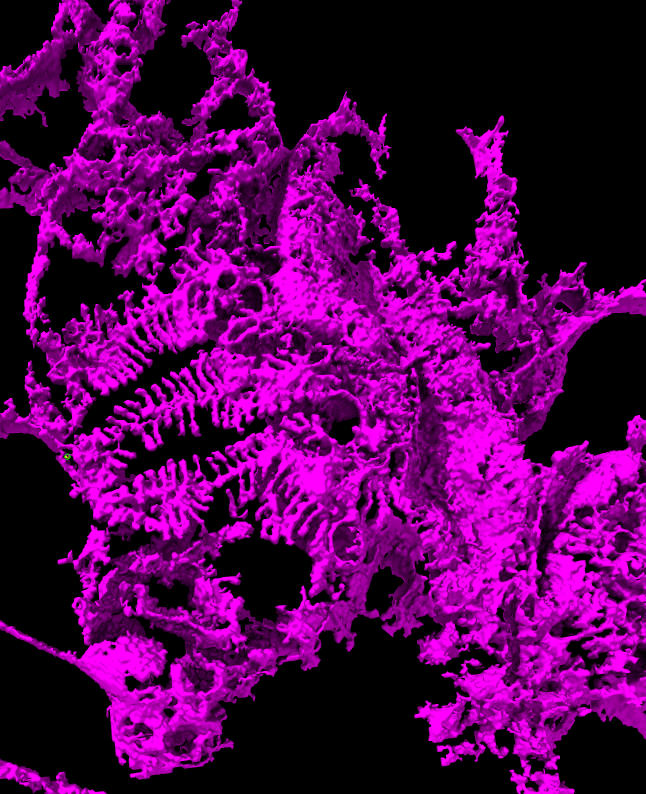

3D bernson attempt for thresholding this volume appears to fail in some 2D frames. My impression is that this is due to the 3X axial long psf from aquaisition of the data on a confocal microscope.

Next attempt will be to explore this method in a 2d iterative formate. 

In [ ]:
mask=ArrayGridData(telp,step=(1,1,2))
volume_from_grid_data(mask,session)

Interested in using a k means clustering approach to defining bright pixels I've decided to implement a k means cluster approach to refine input images before attempting the bernson thresholding.

In [ ]:
pip install -U scikit-learn

In [ ]:
import sklearn
from chimerax.map_data import ArrayGridData 
from chimerax.map import volume_from_grid_data
import itertools
import numpy
import scipy
import skimage
from time import time
import sklearn

In [ ]:
s=time()
y=session.models[2].volume.full_matrix().copy()
p= session.models[3].atoms.coords
bg=4500
telp=numpy.zeros(numpy.shape(y))
oop=numpy.zeros(numpy.shape(y))
def goop(p,onion):
    n= 50
    p=numpy.round(p).astype('int')

    a=numpy.linspace(p[0,0]-n,p[0,0]+n, n*2)
    b=numpy.linspace(p[0,1]-n,p[0,1]+n, n*2)
    c=numpy.array([on])

    q=numpy.array(list(itertools.product(*(a,b,c),repeat=1)),dtype='int')
    return q


In [ ]:
s=time()
y=session.models[2].volume.full_matrix().copy()
p= session.models[3].atoms.coords
st=time()
bg=4500
telp=numpy.zeros(numpy.shape(y))
oop=numpy.zeros(numpy.shape(y))
def goop(p,on):
    n= 300
    p=numpy.round(p).astype('int')

    a=numpy.linspace(p[0,0]-n,p[0,0]+n, n*2)
    b=numpy.linspace(p[0,1]-n,p[0,1]+n, n*2)
    c=numpy.array([on])

    q=numpy.array(list(itertools.product(*(a,b,c),repeat=1)),dtype='int')
    w=numpy.split(q,3,1)

    cl=numpy.nanmean(y[w[2],w[1],w[0]])
    return q, cl
en=time()

for on in range (0,89):
    on=on
    q,cl = goop(p=p,on=on)
    qtree=scipy.spatial.KDTree(q)
    index = qtree.query_ball_point(q, r=4, workers=-1)

    """generates a single 1d array with array 1d index"""
    '''Smoothing to keep a nice surface'''
    tl=y-(numpy.zeros(numpy.shape(y))+bg)
    mask = (tl>0)
    l=scipy.ndimage.gaussian_filter(tl,sigma=.2,truncate=1)*mask
    def loop_ROI(q,index,l,mask):
        lp=numpy.zeros(numpy.shape(y))
        elp=numpy.zeros(numpy.shape(y))
        for ind in range (0,numpy.shape(index)[0]):
            tz,ty,tx = numpy.split(numpy.flip(q[index[ind]],axis=1),3,1)

            x,yy,z = q[ind]
            standardD = numpy.nanstd(l[tz,ty,tx])*0.05 
            Thresh= ((((numpy.nanmax(l[tz,ty,tx])*0.9)-numpy.nanmin(l[tz,ty,tx])*.5))/2)+standardD
            contrast= (numpy.nanmax(l[tz,ty,tx])-numpy.nanmin(l[tz,ty,tx])) 

            lp[z,yy,x] = (contrast > (0.7*cl)) * (l[z,yy,x] >= Thresh*.9)
            elp[z,yy,x] = lp[z,yy,x]*mask[z,yy,x]
        return elp, lp

e=time()
print(e-s)

In [ ]:
mask=ArrayGridData(oop,step=(1,1,2))
volume_from_grid_data(mask,session)

In [ ]:
s=time()
y=session.models[2].volume.full_matrix().copy()
p= session.models[3].atoms.coords
bg=4500
telp=numpy.zeros(numpy.shape(y))
oop=numpy.zeros(numpy.shape(y))
def goop(p,on):
    n= 60
    p=numpy.round(p).astype('int')

    a=numpy.linspace(p[0,0]-n,p[0,0]+n, n*2)
    b=numpy.linspace(p[0,1]-n,p[0,1]+n, n*2)
    c=numpy.array([on])

    q=numpy.array(list(itertools.product(*(a,b,c),repeat=1)),dtype='int')
    w=numpy.split(q,3,1)

    cl=numpy.nanmean(y[w[2],w[1],w[0]])
    return q, cl

lp=numpy.zeros(numpy.shape(y))
elp=numpy.zeros(numpy.shape(y))

for on in range (180,220):
    on=on
    q,cl = goop(p=p,on=on)
    qtree=scipy.spatial.KDTree(q)
    index = qtree.query_ball_point(q, r=4, workers=-1)

    """generates a single 1d array with array 1d index"""
    '''Smoothing to keep a nice surface'''
    tl=y-(numpy.zeros(numpy.shape(y))+bg)
    mask = (tl>0)
    l=scipy.ndimage.gaussian_filter(tl,sigma=.2,truncate=1)*mask

    def loop_ROI(q,index,l,mask):

        for ind in range (0,numpy.shape(index)[0]):
            tz,ty,tx = numpy.split(numpy.flip(q[index[ind]],axis=1),3,1)

            x,yy,z = q[ind]
            standardD = numpy.nanstd(l[tz,ty,tx])*0.05 
            Thresh= ((((numpy.nanmax(l[tz,ty,tx])*0.9)-numpy.nanmin(l[tz,ty,tx])*2))/2)+standardD
            contrast= (numpy.nanmax(l[tz,ty,tx])-numpy.nanmin(l[tz,ty,tx])) 

            lp[z,yy,x] = (contrast > (0.7*cl)) * (l[z,yy,x] >= Thresh*.9)
            elp[z,yy,x] = lp[z,yy,x]*mask[z,yy,x]
        return elp, lp

    elp,lp = loop_ROI(q = q, index = index,l=l,mask=mask)
    poop= skimage.morphology.binary_dilation(lp)
    poop= skimage.morphology.binary_dilation(poop)
    poop= skimage.morphology.binary_dilation(poop)
    for_clustering = y*poop

for on in range (72,72):
    on=on
    q,cl = goop(p=p,on=on)
    qtree=scipy.spatial.KDTree(q)
    index = qtree.query_ball_point(q, r=5, workers=-1)

    def loop_ROI(q,index,l,mask):
            ree=numpy.zeros(numpy.shape(y))
            tee=numpy.zeros(numpy.shape(y))
            for ind in range (0,numpy.shape(index)[0]):
                tz,ty,tx = numpy.split(numpy.flip(q[index[ind]],axis=1),3,1)

                x,yy,z = q[ind]
                cluster = sklearn.cluster.OPTICS(min_samples=5,max_eps=10).fit(for_clustering[tz,ty,tx])

e=time()
print(e-s)

cluster ouptut (intensity vs cluster) initial tesst showed promiss witht his though it may be benificial to use this cluster approach on all datat/ increase the size of the querry and alyering the results and building confidense in the clusters

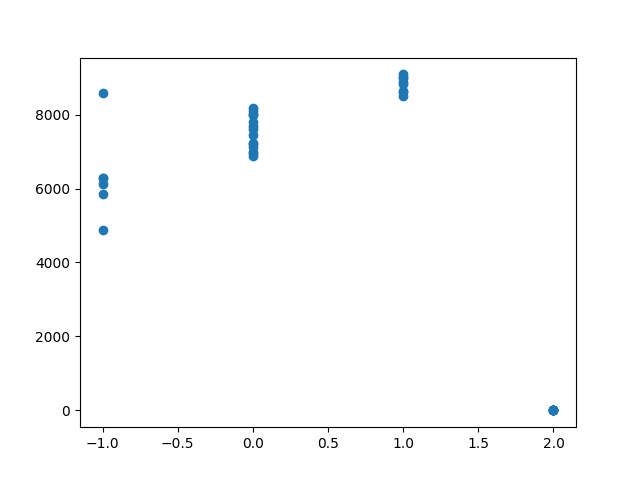

In [ ]:
mask=ArrayGridData(for_clustering,step=(1,1,2))
volume_from_grid_data(mask,session)

In [ ]:
on=72
q,cl = goop(p=p,on=on)
qtree=scipy.spatial.KDTree(q)
index = qtree.query_ball_point(q, r=5, workers=-1)

ind=3090

tz,ty,tx = numpy.split(numpy.flip(q[index[ind]],axis=1),3,1)

x,yy,z = q[ind]
cluster = sklearn.cluster.OPTICS(min_samples=5).fit(for_clustering[tz,ty,tx])



Quick trnasition to llsm data

In [ ]:
s=time()
y=session.models[2].volume.full_matrix().copy()
p= session.models[3].atoms.coords
bg=240
telp=numpy.zeros(numpy.shape(y))
oop=numpy.zeros(numpy.shape(y))
def goop(p,on):
    n= 60
    p=numpy.round(p).astype('int')

    a=numpy.linspace(p[0,0]-n,p[0,0]+n, n*2)
    b=numpy.linspace(p[0,1]-n,p[0,1]+n, n*2)
    c=numpy.array([on])

    q=numpy.array(list(itertools.product(*(a,b,c),repeat=1)),dtype='int')
    w=numpy.split(q,3,1)

    cl=numpy.nanmean(y[w[2],w[1],w[0]])
    return q, cl

lp=numpy.zeros(numpy.shape(y))
elp=numpy.zeros(numpy.shape(y))

for on in range (180,220):
    on=on
    q,cl = goop(p=p,on=on)
    qtree=scipy.spatial.KDTree(q)
    index = qtree.query_ball_point(q, r=4, workers=-1)

    """generates a single 1d array with array 1d index"""
    '''Smoothing to keep a nice surface'''
    tl=y-(numpy.zeros(numpy.shape(y))+bg)
    mask = (tl>0)
    l=scipy.ndimage.gaussian_filter(tl,sigma=.2,truncate=1)*mask

    def loop_ROI(q,index,l,mask):

        for ind in range (0,numpy.shape(index)[0]):
            tz,ty,tx = numpy.split(numpy.flip(q[index[ind]],axis=1),3,1)

            x,yy,z = q[ind]
            standardD = numpy.nanstd(l[tz,ty,tx])*0.05 
            Thresh= ((((numpy.nanmax(l[tz,ty,tx])*0.9)-numpy.nanmin(l[tz,ty,tx])*2))/2)+standardD
            contrast= (numpy.nanmax(l[tz,ty,tx])-numpy.nanmin(l[tz,ty,tx])) 

            lp[z,yy,x] = (contrast > (0.7*cl)) * (l[z,yy,x] >= Thresh*.9)
            elp[z,yy,x] = lp[z,yy,x]*mask[z,yy,x]
        return elp, lp

    elp,lp = loop_ROI(q = q, index = index,l=l,mask=mask)
    st=time()
    timer=st-s

Below segments bright points well. Attempt to cluster and find bright nodes 2d approach might work well (spatial location and intensity)

s=time()
y=session.models[2].volume.full_matrix().copy()
p= session.models[3].atoms.coords
bg=3500
telp=numpy.zeros(numpy.shape(y))
oop=numpy.zeros(numpy.shape(y))
def goop(p,on):
    n= 250
    p=numpy.round(p).astype('int')

    a=numpy.linspace(p[0,0]-n,p[0,0]+n, n*2)
    b=numpy.linspace(p[0,1]-n,p[0,1]+n, n*2)
    c=numpy.array([on])

    q=numpy.array(list(itertools.product(*(a,b,c),repeat=1)),dtype='int')
    w=numpy.split(q,3,1)

    cl=numpy.nanmean(y[w[2],w[1],w[0]])
    return q, cl

lp=numpy.zeros(numpy.shape(y))
elp=numpy.zeros(numpy.shape(y))

for on in range (80,150):
    on=on
    q,cl = goop(p=p,on=on)
    qtree=scipy.spatial.KDTree(q)
    index = qtree.query_ball_point(q, r=4, workers=-1)

    """generates a single 1d array with array 1d index"""
    '''Smoothing to keep a nice surface'''
    tl=y-(numpy.zeros(numpy.shape(y))+bg)
    mask = (tl>0)
    l=scipy.ndimage.gaussian_filter(tl,sigma=.4,truncate=2)*mask

    def loop_ROI(q,index,l,mask):

        for ind in range (0,numpy.shape(index)[0]):
            tz,ty,tx = numpy.split(numpy.flip(q[index[ind]],axis=1),3,1)

            x,yy,z = q[ind]
            standardD = numpy.nanstd(l[tz,ty,tx])*0.1 
            Thresh= ((((numpy.nanmax(l[tz,ty,tx]))-numpy.nanmin(l[tz,ty,tx])*1.25))/2)+standardD
            contrast= (numpy.nanmax(l[tz,ty,tx])-numpy.nanmin(l[tz,ty,tx])) 

            lp[z,yy,x] = (contrast > (0.7*cl)) * (l[z,yy,x] >= Thresh*.9)
            elp[z,yy,x] = lp[z,yy,x]*mask[z,yy,x]
        return elp, lp

    elp,lp = loop_ROI(q = q, index = index,l=l,mask=mask)
    st=time()
    timer=st-s

mask=ArrayGridData(elp,step=(1,1,2))
volume_from_grid_data(mask,session)

In [ ]:
'''poop= skimage.morphology.binary_dilation(lp)
poop= skimage.morphology.binary_dilation(poop)
poop= skimage.morphology.binary_dilation(poop)'''
for_clustering = y*lp


space=numpy.where(for_clustering>0)
pepsi=numpy.zeros((numpy.size(space[1]),4))
pepsi[:,0]=space[0]
pepsi[:,1]=space[2]
pepsi[:,2]=space[1]
pepsi[:,3]=y[space[0],space[1],space[2]]

cluster = sklearn.cluster.OPTICS(eps=50,min_samples=25,algorithm='auto',leaf_size=250).fit(pepsi)
for i in range (-1,numpy.max(cluster.labels_)):
    pip=pepsi[numpy.where(cluster.labels_==i),0:3]
    zs=numpy.int64(numpy.split(pip[:,:][0],3,1)[0])
    ys=numpy.int64(numpy.split(pip[:,:][0],3,1)[2])
    xs=numpy.int64(numpy.split(pip[:,:][0],3,1)[1])
    hs=numpy.zeros(numpy.shape(y))
    hs[zs,ys,xs]=1
    mask=ArrayGridData(hs,step=(1,1,2))
    volume_from_grid_data(mask,session)

In [ ]:
pepsi[space[0],space[1],space[2]]=y[space[0],space[1],space[2]]

In [ ]:

_,cluster = sklearn.cluster.dbscan(pepsi,eps=.1, metric='euclidean',min_samples=10,algorithm='auto',leaf_size=25)
for i in range (-1,numpy.max(cluster)):
    pip=pepsi[numpy.where(cluster==i),0:3]
    zs=numpy.int64(numpy.split(pip[:,:][0],3,1)[0])
    ys=numpy.int64(numpy.split(pip[:,:][0],3,1)[2])
    xs=numpy.int64(numpy.split(pip[:,:][0],3,1)[1])
    hs=numpy.zeros(numpy.shape(y))
    hs[zs,ys,xs]=1
    mask=ArrayGridData(hs,step=(1,1,2))
    volume_from_grid_data(mask,session)

In [ ]:
'''poop= skimage.morphology.binary_dilation(lp)
poop= skimage.morphology.binary_dilation(poop)
poop= skimage.morphology.binary_dilation(poop)'''
for_clustering = y*lp


space=numpy.where(for_clustering>0)
pepsi=numpy.zeros((numpy.size(space[1]),5))
pepsi[:,0]=space[0]
pepsi[:,1]=space[2]
pepsi[:,2]=space[1]


pepsi[:,3]=numpy.arccos(z_coord / ) * (180/pi)
pepsi[:,4]=numpy.abs(numpy.sqrt(space[0]**2+space[2]**2+space[2]**2))
pepsi[:,5]=scipy.ndimage.gaussian_filter(y[space[0],space[1],space[2]],sigma=1, truncate=8)

cluster = sklearn.cluster.KMeans(n_clusters=2,max_iter=1000).fit(scipy.ndimage.gaussian_filter(y[space[0],space[1],space[2]],sigma=1, truncate=8)
)
for i in range (-1,numpy.max(cluster.labels_)):
    pip=pepsi[numpy.where(cluster.labels_==i),0:3]
    zs=numpy.int64(numpy.split(pip[:,:][0],3,1)[0])
    ys=numpy.int64(numpy.split(pip[:,:][0],3,1)[2])
    xs=numpy.int64(numpy.split(pip[:,:][0],3,1)[1])
    hs=numpy.zeros(numpy.shape(y))
    hs[zs,ys,xs]=1
    mask=ArrayGridData(hs,step=(1,1,2))
    volume_from_grid_data(mask,session)

In [ ]:
st=time()
for_clustering = y*lp


space=numpy.where(for_clustering>0)
pepsi=numpy.zeros((numpy.size(space[1]),4))
pepsi[:,0]=space[0]
pepsi[:,1]=space[2]
pepsi[:,2]=space[1]
pepsi[:,3]=y[space[0],space[1],space[2]]

cluster = sklearn.cluster.KMeans(n_clusters=4,max_iter=10).fit(pepsi)
for i in range (-1,numpy.max(cluster.labels_)):
    pip=pepsi[numpy.where(cluster.labels_==i),0:3]
    zs=numpy.int64(numpy.split(pip[:,:][0],3,1)[0])
    ys=numpy.int64(numpy.split(pip[:,:][0],3,1)[2])
    xs=numpy.int64(numpy.split(pip[:,:][0],3,1)[1])
    hs=numpy.zeros(numpy.shape(y))
    hs[zs,ys,xs]=1
    mask=ArrayGridData(hs,step=(1,1,2))
    volume_from_grid_data(mask,session)

s=time()
timer=(st-s)/60

Output for code below for kmean cluster's bright and shells
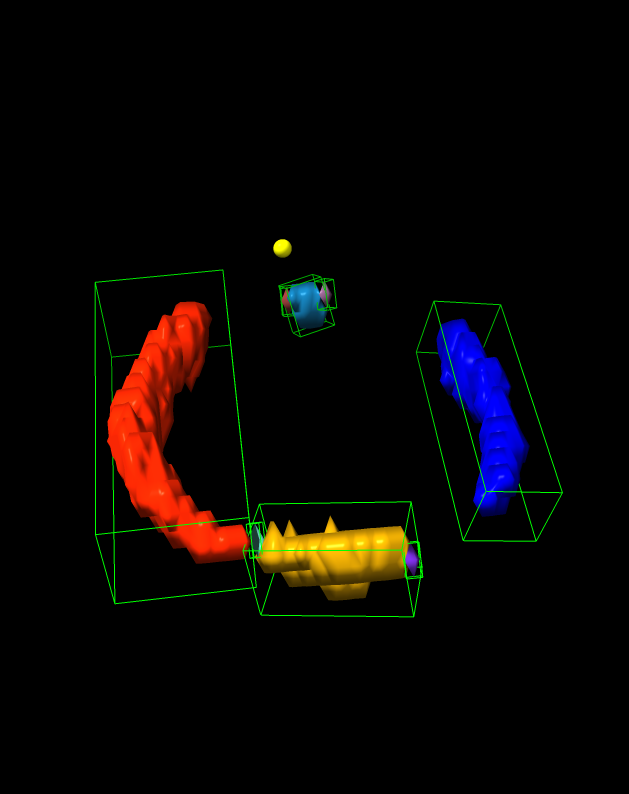 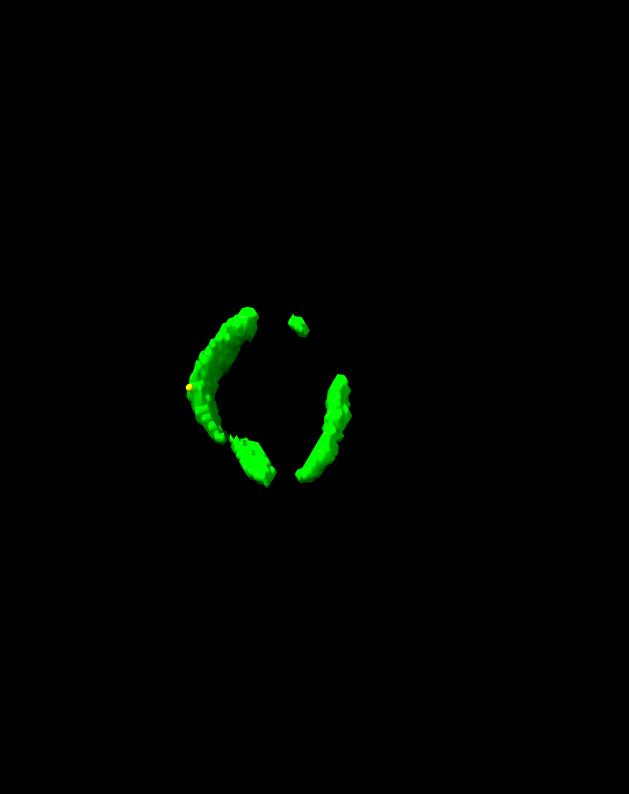 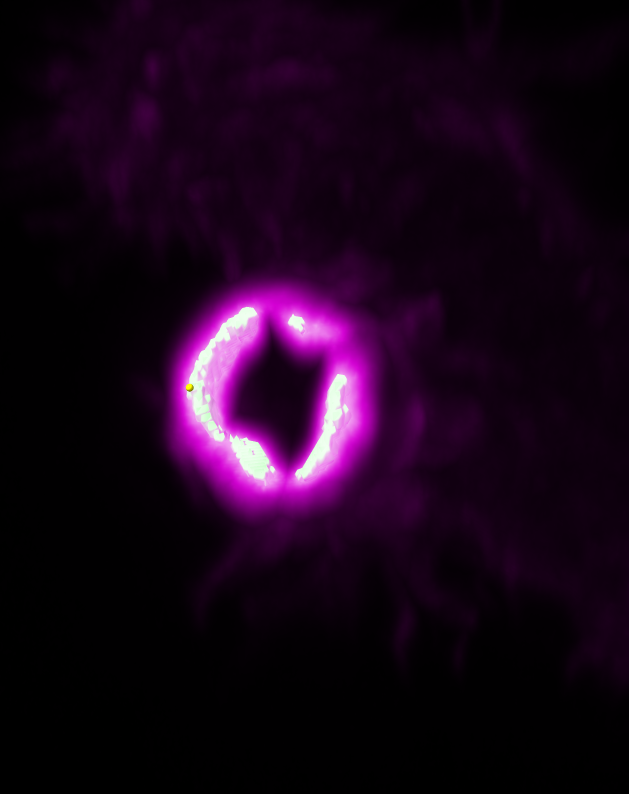 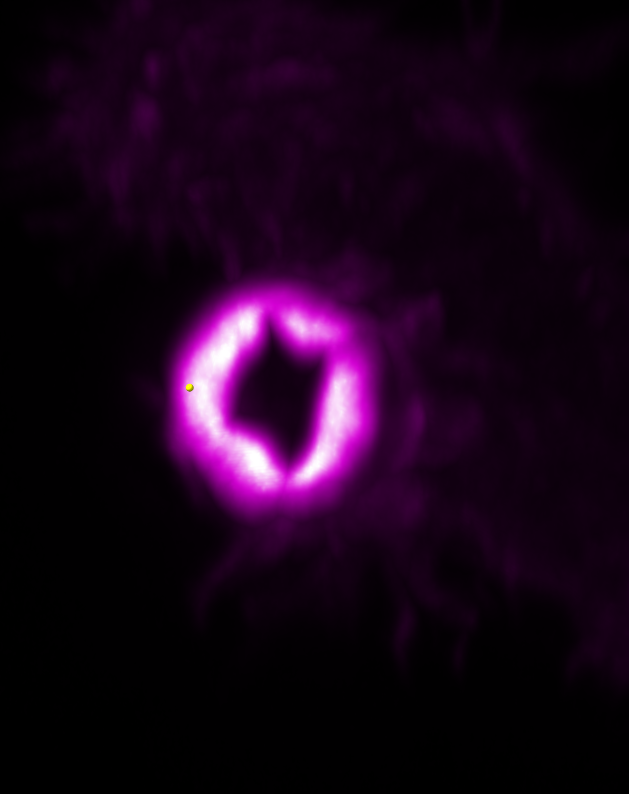 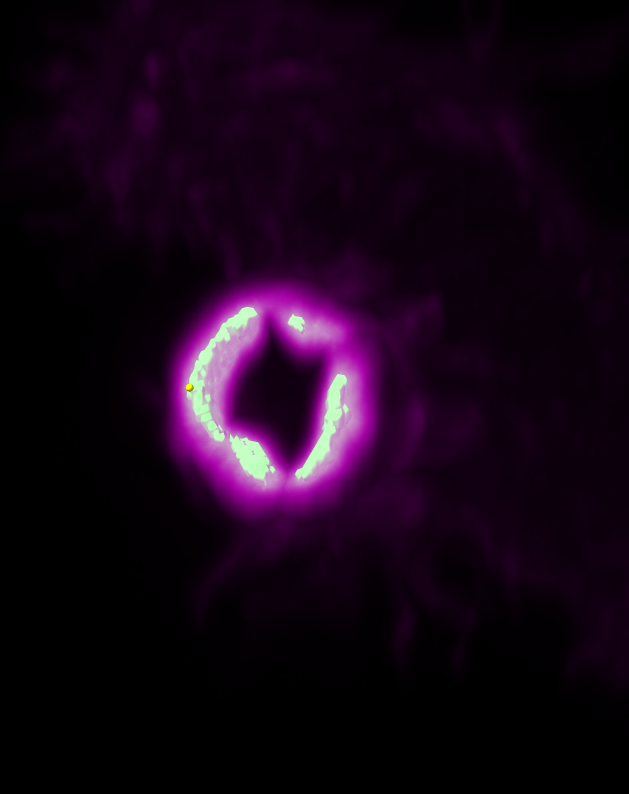 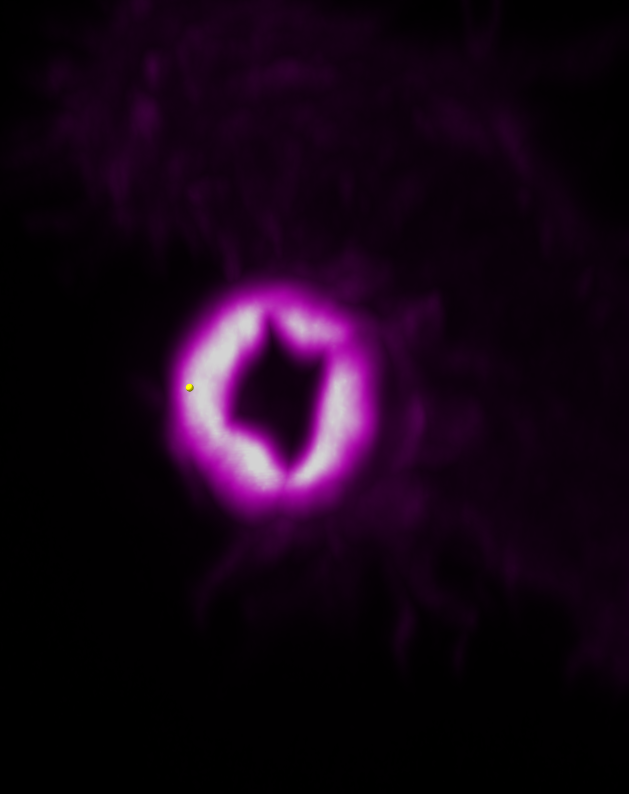 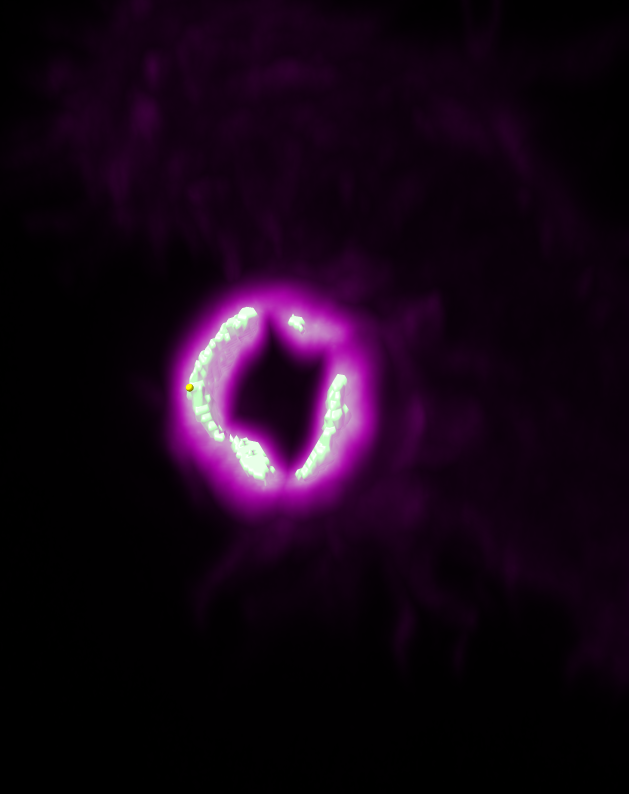


In [ ]:
for_clustering = y*lp


space=numpy.where(for_clustering>0)
pepsi=numpy.zeros((numpy.size(space[1]),4))
pepsi[:,0]=space[0]
pepsi[:,1]=space[2]
pepsi[:,2]=space[1]
pepsi[:,3]=y[space[0],space[1],space[2]]

cluster = sklearn.cluster.KMeans(n_clusters=8,max_iter=100).fit(pepsi)
for i in range (-1,numpy.max(cluster.labels_)):
    pip=pepsi[numpy.where(cluster.labels_==i),0:3]
    zs=numpy.int64(numpy.split(pip[:,:][0],3,1)[0])
    ys=numpy.int64(numpy.split(pip[:,:][0],3,1)[2])
    xs=numpy.int64(numpy.split(pip[:,:][0],3,1)[1])
    hs=numpy.zeros(numpy.shape(y))
    hs[zs,ys,xs]=1
    mask=ArrayGridData(hs,step=(1,1,2))
    volume_from_grid_data(mask,session)

20240731

Appears that using this kmeans approach to cluster brigh regions in the image using a 4D feature set (x,y,z,I) makes the assumption that there are a specific number of clusters. As the users increases the number of clusters we often only end up with a solid batch groupped in a cluster that consist of "bright" pixels in the ROI and most other clusters are apart of the outter regions of the intensity gradient proximal to the bright ROIs, all other clusters are various regions of the the pseudopodia comprising the phagocytic cup. Using the eulers characteristic in Skimage allows use to define the clusters that are solid from other that are not. This may allow for a automatic approach to solving for best cluster result for "bright" solid cluster segmentation. Subsequent work can be done to build information for diffuse cloude of intensity values.

![Screenshot 2025-07-31 152124.png](<attachment:Screenshot 2025-07-31 152124.png>) ![Screenshot 2025-07-31 152732.png](<attachment:Screenshot 2025-07-31 152732.png>)
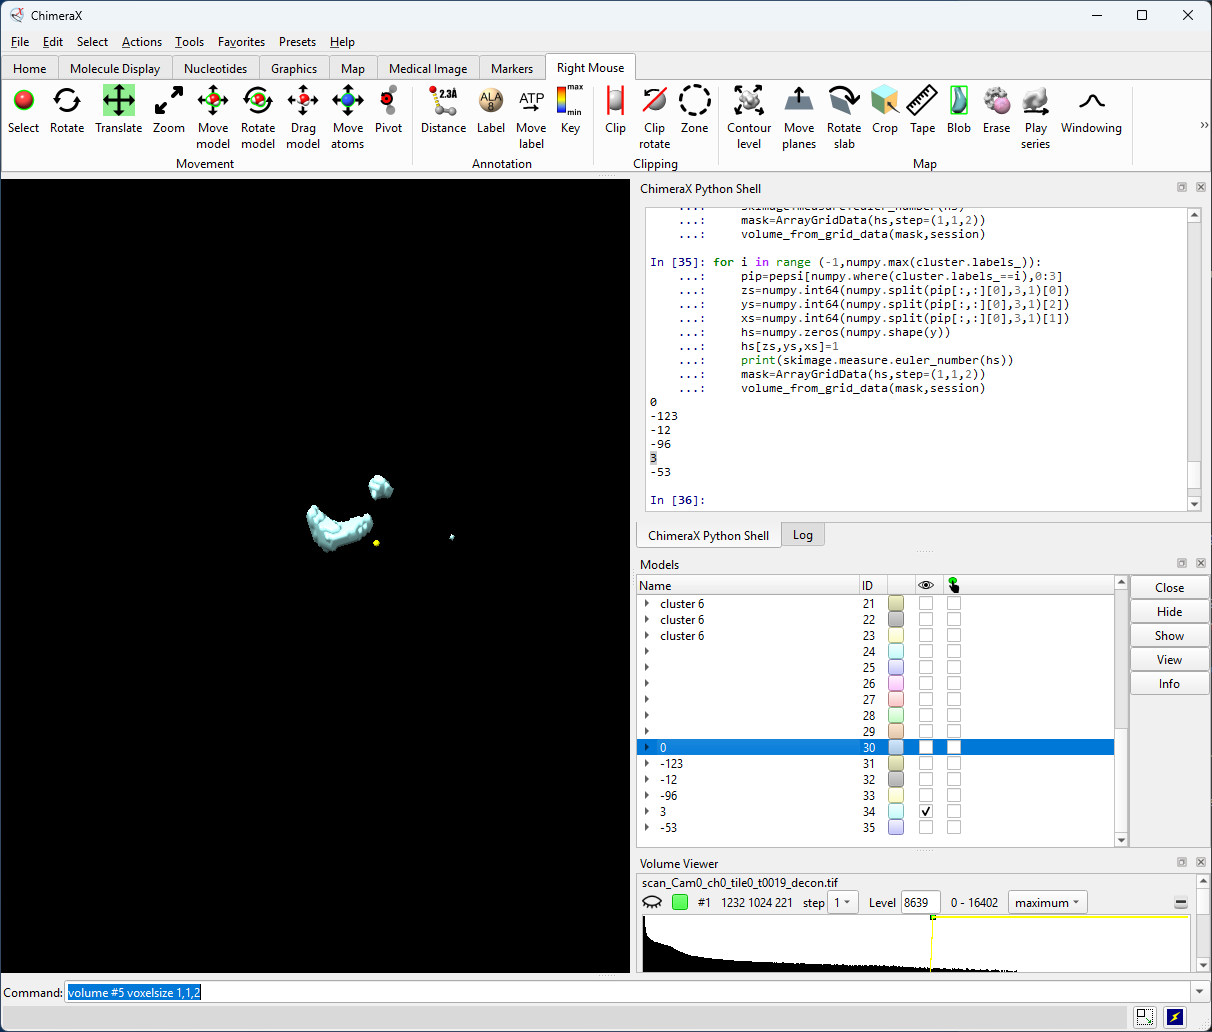
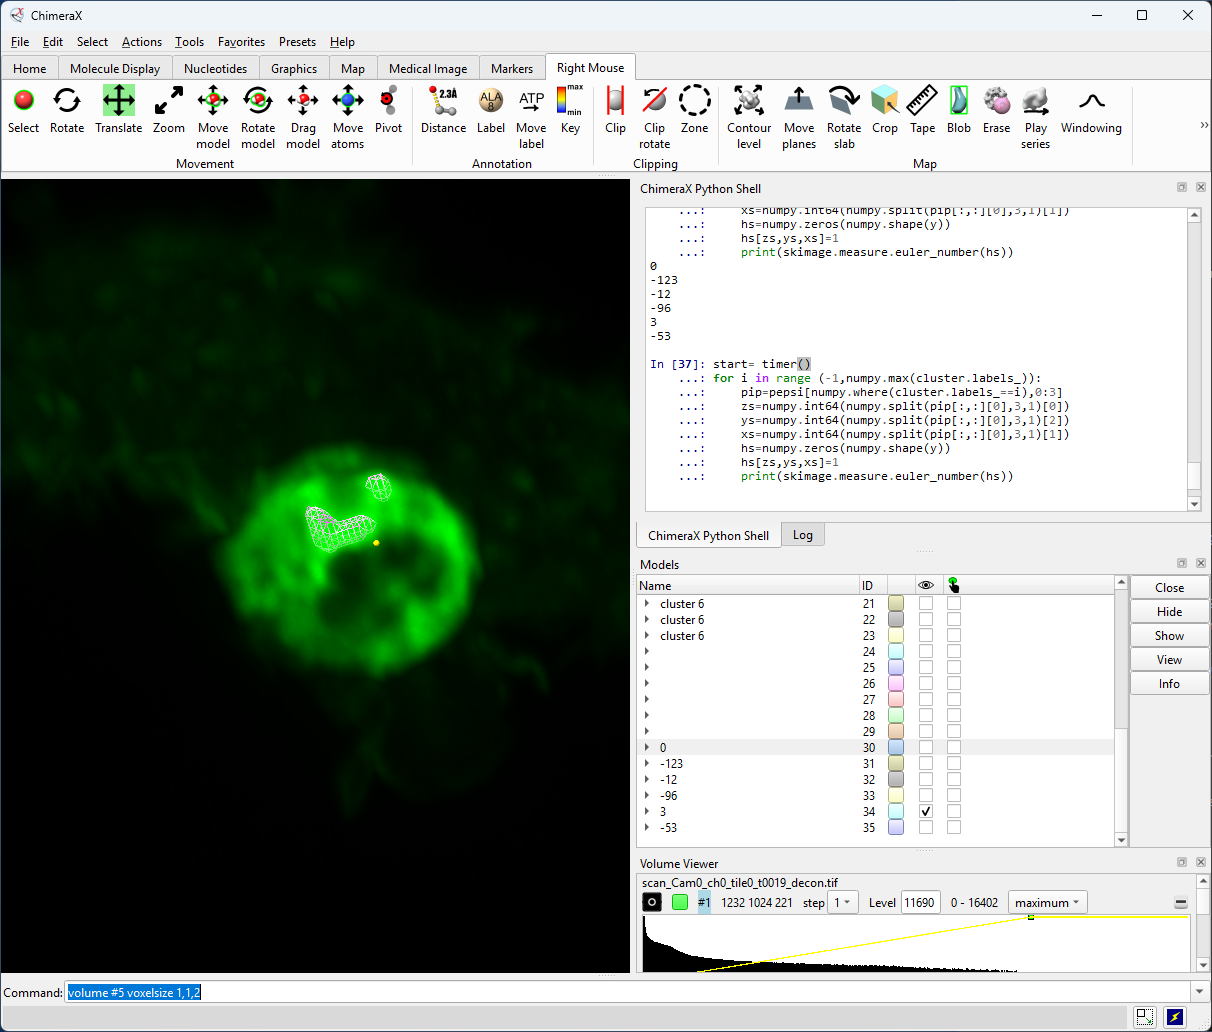

Seems like the euler number critera assist in defining mask where clusters lie.

![YML_Newsletter Thing.png](<attachment:YML_Newsletter Thing.png>)
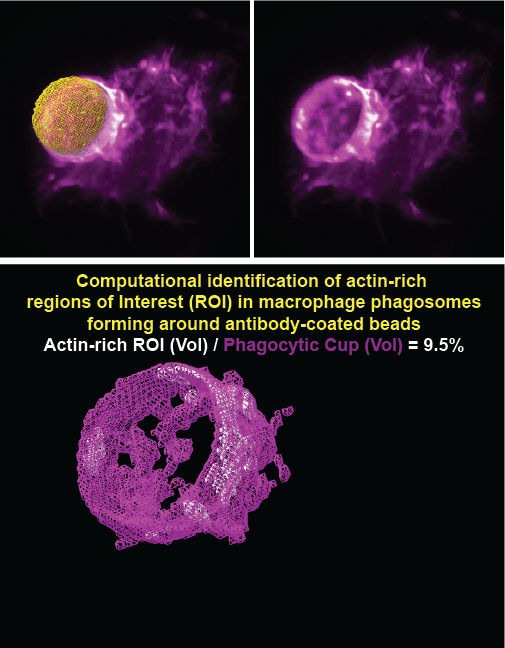

![Screenshot 2025-09-04 154854.png](<attachment:Screenshot 2025-09-04 154854.png>)
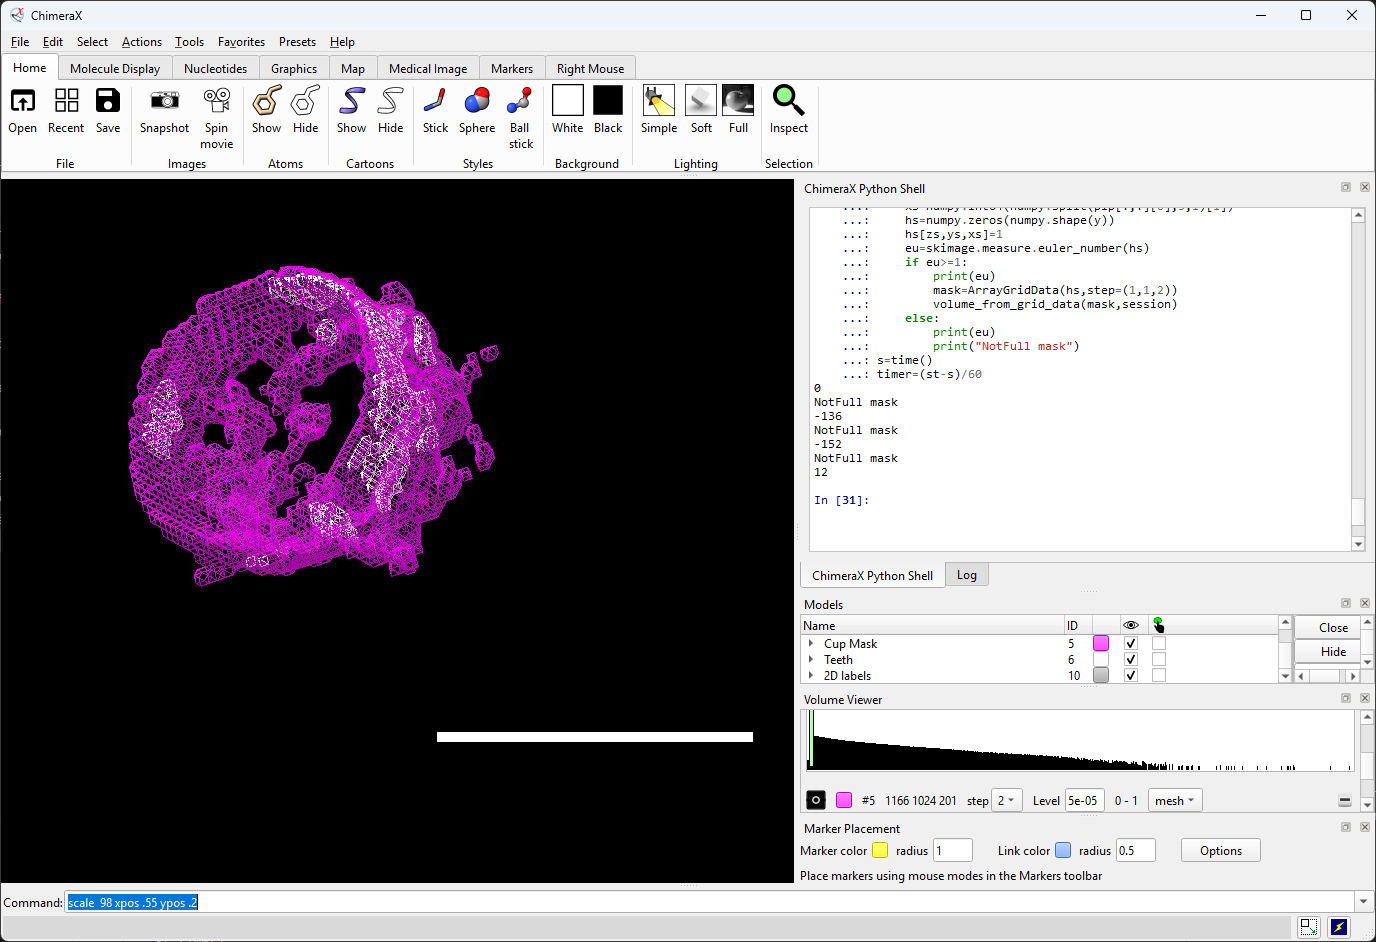

In [ ]:
st=time()
for_clustering = y*lp


space=numpy.where(for_clustering>0)
pepsi=numpy.zeros((numpy.size(space[1]),4))
pepsi[:,0]=space[0]
pepsi[:,1]=space[2]
pepsi[:,2]=space[1]
pepsi[:,3]=y[space[0],space[1],space[2]]

cluster = sklearn.cluster.KMeans(n_clusters=4,max_iter=10).fit(pepsi)
for i in range (-1,numpy.max(cluster.labels_)):
    pip=pepsi[numpy.where(cluster.labels_==i),0:3]
    zs=numpy.int64(numpy.split(pip[:,:][0],3,1)[0])
    ys=numpy.int64(numpy.split(pip[:,:][0],3,1)[2])
    xs=numpy.int64(numpy.split(pip[:,:][0],3,1)[1])
    hs=numpy.zeros(numpy.shape(y))
    hs[zs,ys,xs]=1
    eu=skimage.measure.euler_number(hs)
    if eu>=1:
        print(eu)
        mask=ArrayGridData(hs,step=(1,1,2))
        volume_from_grid_data(mask,session)
    else:
        print(eu)
        print("NotFull mask")
s=time()
timer=(st-s)/60

Iteration of this clustering for shape until a good mask is displayed

In [ ]:
st=time()
for_clustering = y*lp


space=numpy.where(for_clustering>0)
pepsi=numpy.zeros((numpy.size(space[1]),4))
pepsi[:,0]=space[0]
pepsi[:,1]=space[2]
pepsi[:,2]=space[1]
pepsi[:,3]=y[space[0],space[1],space[2]]

for qq in range (1,10):
    cluster = sklearn.cluster.KMeans(n_clusters=qq,max_iter=10).fit(pepsi)
    for i in range (-1,numpy.max(cluster.labels_)):
        pip=pepsi[numpy.where(cluster.labels_==i),0:3]
        zs=numpy.int64(numpy.split(pip[:,:][0],3,1)[0])
        ys=numpy.int64(numpy.split(pip[:,:][0],3,1)[2])
        xs=numpy.int64(numpy.split(pip[:,:][0],3,1)[1])
        hs=numpy.zeros(numpy.shape(y))
        hs[zs,ys,xs]=1
        eu=skimage.measure.euler_number(hs)
        if eu>=1:
            print(eu, '>= 1')
            print('cluster assumpt ==', qq)
            mask=ArrayGridData(hs,step=(1,1,2))
            volume_from_grid_data(mask,session)
            break
        else:
            print(eu)
            print("NotFull mask")
    break
        

s=time()
timer=(st-s)/60

In [ ]:
s=time()
y=session.models[5].volume.full_matrix().copy()
p= session.models[7].atoms.coords
bg=1800
telp=numpy.zeros(numpy.shape(y))
oop=numpy.zeros(numpy.shape(y))
def goop(p,on):
    n= 75
    p=numpy.round(p).astype('int')

    a=numpy.linspace(p[0,0]-n,p[0,0]+n, n*2)
    b=numpy.linspace(p[0,1]-n,p[0,1]+n, n*2)
    c=numpy.array([on])

    q=numpy.array(list(itertools.product(*(a,b,c),repeat=1)),dtype='int')
    w=numpy.split(q,3,1)

    cl=numpy.nanmean(y[w[2],w[1],w[0]])
    return q, cl

lp=numpy.zeros(numpy.shape(y))
elp=numpy.zeros(numpy.shape(y))

for on in range (0,91):
    on=on
    q,cl = goop(p=p,on=on)
    qtree=scipy.spatial.KDTree(q)
    index = qtree.query_ball_point(q, r=4, workers=-1)

    """generates a single 1d array with array 1d index"""
    '''Smoothing to keep a nice surface'''
    tl=y-(numpy.zeros(numpy.shape(y))+bg)
    mask = (tl>0)
    l=scipy.ndimage.gaussian_filter(tl,sigma=.4,truncate=2)*mask

    def loop_ROI(q,index,l,mask):

        for ind in range (0,numpy.shape(index)[0]):
            tz,ty,tx = numpy.split(numpy.flip(q[index[ind]],axis=1),3,1)

            x,yy,z = q[ind]
            standardD = numpy.nanstd(l[tz,ty,tx])*0.1 
            Thresh= ((((numpy.nanmax(l[tz,ty,tx]))-numpy.nanmin(l[tz,ty,tx])*1.25))/2)+standardD
            contrast= (numpy.nanmax(l[tz,ty,tx])-numpy.nanmin(l[tz,ty,tx])) 

            lp[z,yy,x] = (contrast > (0.7*cl)) * (l[z,yy,x] >= Thresh*.9)
            elp[z,yy,x] = lp[z,yy,x]*mask[z,yy,x]
        return elp, lp

    elp,lp = loop_ROI(q = q, index = index,l=l,mask=mask)
    st=time()
    timer=st-s

For suppory summary
Glom setting (decent)


In [ ]:
def glom_seg():
    s=time()
    y=session.models[5].volume.full_matrix().copy()
        
    def background(y):
        bg=numpy.average(y)+(numpy.std(y)*0.75)
        return bg
    bg= background(y=y)

    telp=numpy.zeros(numpy.shape(y))
    oop=numpy.zeros(numpy.shape(y))

    """assume symmetry over the image in x / y"""
    def telegraph(y):
        xsteps= numpy.round(numpy.linspace(0,numpy.shape(y)[1]-1,(numpy.round(numpy.shape(y)[1]/100).astype('int64'))))[1:-1]-1
        ysteps= numpy.round(numpy.linspace(0,numpy.shape(y)[2]-1,(numpy.round(numpy.shape(y)[2]/100).astype('int64'))))[1:-1]-1
        return xsteps,ysteps
    
    xsteps,ysteps = telegraph(y=y)

    
    for steppingx in range (0,numpy.shape(xsteps)[0]):
        for steppingy in range (0,numpy.shape(ysteps)[0]):
            def goop(xsteps,ysteps,y):
                n= xsteps[0].astype('int64')
                nx=xsteps[steppingx].astype('int64')
                ny=ysteps[steppingy].astype('int64')

                a=numpy.linspace(nx-n,nx+n, 1+(n*2))
                b=numpy.linspace(ny-n,ny+n, 1+(n*2))
                c=numpy.linspace(0,numpy.shape(y)[0]-1,numpy.shape(y)[0])

                q=numpy.array(list(itertools.product(*(a,b,c),repeat=1)),dtype='int')
                w=numpy.split(q,3,1)

                cl=numpy.nanmean(y[w[2],w[1],w[0]])
                return q, cl

            lp=numpy.zeros(numpy.shape(y))
            elp=numpy.zeros(numpy.shape(y))

            def FindPoints():
                q,cl = goop(xsteps,ysteps,y)
                qtree=scipy.spatial.KDTree(q)
                index = qtree.query_ball_point(q, r=3, workers=-1)

                """generates a single 1d  array with array 1d index"""
                '''Smoothing to keep a nice surface'''
                tl=y-(numpy.zeros(numpy.shape(y))+bg)
                mask = (tl>0)
                l=scipy.ndimage.gaussian_filter(tl,sigma=.4,truncate=2)*mask
                return q,index,l,mask,cl

            def loop_ROI(q,index,l,mask,cl):

                for ind in range (0,numpy.shape(index)[0]):
                    tz,ty,tx = numpy.split(numpy.flip(q[index[ind]],axis=1),3,1)

                    x,yy,z = q[ind]
                    standardD = numpy.nanstd(l[tz,ty,tx])*0.1 
                    Thresh= ((((numpy.nanmax(l[tz,ty,tx]))-numpy.nanmin(l[tz,ty,tx])*1.25))/2)+standardD
                    contrast= (numpy.nanmax(l[tz,ty,tx])-numpy.nanmin(l[tz,ty,tx])) 

                    lp[z,yy,x] = (contrast > (0.75*cl)) * (l[z,yy,x] >= Thresh*.9)
                    elp[z,yy,x] = lp[z,yy,x]*mask[z,yy,x]
                return elp, lp
            q,index,l,mask,cl = FindPoints()
            elp,lp = loop_ROI(q = q, index = index,l=l,mask=mask,cl=cl)
            telp=(telp.astype('int64')+elp)>=1
    st=time()
    timer=st-s
    return telp,elp,timer

Simple adaptation for capilarry

In [ ]:
def glom_seg():
    s=time()
    y=session.models[5].volume.full_matrix().copy()
        
    def background(y):
        bg=numpy.average(y)+(numpy.std(y)*0.75)
        return bg
    bg= background(y=y)

    telp=numpy.zeros(numpy.shape(y))
    oop=numpy.zeros(numpy.shape(y))

    """assume symmetry over the image in x / y"""
    def telegraph(y):
        xsteps= numpy.round(numpy.linspace(0,numpy.shape(y)[1]-1,(numpy.round(numpy.shape(y)[1]/100).astype('int64'))))[1:-1]-1
        ysteps= numpy.round(numpy.linspace(0,numpy.shape(y)[2]-1,(numpy.round(numpy.shape(y)[2]/100).astype('int64'))))[1:-1]-1
        return xsteps,ysteps
    
    xsteps,ysteps = telegraph(y=y)

    
    for steppingx in range (0,numpy.shape(xsteps)[0]):
        for steppingy in range (0,numpy.shape(ysteps)[0]):
            def goop(xsteps,ysteps,y):
                n= xsteps[0].astype('int64')
                nx=xsteps[steppingx].astype('int64')
                ny=ysteps[steppingy].astype('int64')

                a=numpy.linspace(nx-n,nx+n, 1+(n*2))
                b=numpy.linspace(ny-n,ny+n, 1+(n*2))
                c=numpy.linspace(0,numpy.shape(y)[0]-1,numpy.shape(y)[0])

                q=numpy.array(list(itertools.product(*(a,b,c),repeat=1)),dtype='int')
                w=numpy.split(q,3,1)

                cl=numpy.nanmean(y[w[2],w[1],w[0]])
                return q, cl

            lp=numpy.zeros(numpy.shape(y))
            elp=numpy.zeros(numpy.shape(y))

            def FindPoints():
                q,cl = goop(xsteps,ysteps,y)
                qtree=scipy.spatial.KDTree(q)
                index = qtree.query_ball_point(q, r=3, workers=-1)

                """generates a single 1d  array with array 1d index"""
                '''Smoothing to keep a nice surface'''
                tl=y-(numpy.zeros(numpy.shape(y))+bg)
                mask = (tl>0)
                l=scipy.ndimage.gaussian_filter(tl,sigma=.4,truncate=2)*mask
                return q,index,l,mask,cl

            def loop_ROI(q,index,l,mask,cl):

                for ind in range (0,numpy.shape(index)[0]):
                    tz,ty,tx = numpy.split(numpy.flip(q[index[ind]],axis=1),3,1)

                    x,yy,z = q[ind]
                    standardD = numpy.nanstd(l[tz,ty,tx])*0.1 
                    Thresh= ((((numpy.nanmax(l[tz,ty,tx]))-numpy.nanmin(l[tz,ty,tx])*1.25))/2)+standardD
                    contrast= (numpy.nanmax(l[tz,ty,tx])-numpy.nanmin(l[tz,ty,tx])) 

                    lp[z,yy,x] = (contrast < (0.75*cl)) * (l[z,yy,x] >= Thresh*.9)
                    elp[z,yy,x] = lp[z,yy,x]*mask[z,yy,x]
                return elp, lp
            q,index,l,mask,cl = FindPoints()
            elp,lp = loop_ROI(q = q, index = index,l=l,mask=mask,cl=cl)
            telp=(telp.astype('int64')+elp)>=1
    st=time()
    timer=st-s
    return telp,elp,timer

In [ ]:
def cap_seg():
    s=time()
    y=session.models[5].volume.full_matrix().copy()

    def background(y):
        bg=numpy.average(y)+(numpy.std(y)*0.75)
        return bg
    bg= background(y=y)

    telp=numpy.zeros(numpy.shape(y))
    oop=numpy.zeros(numpy.shape(y))

    """assume symmetry over the image in x / y"""
    def telegraph(y):
        xsteps= numpy.round(numpy.linspace(0,numpy.shape(y)[1]-1,(numpy.round(numpy.shape(y)[1]/100).astype('int64'))))[1:-1]-1
        ysteps= numpy.round(numpy.linspace(0,numpy.shape(y)[2]-1,(numpy.round(numpy.shape(y)[2]/100).astype('int64'))))[1:-1]-1
        return xsteps,ysteps

    xsteps,ysteps = telegraph(y=y)
    p=numpy.zeros(numpy.shape(y))
    lp=numpy.zeros(numpy.shape(y))
    elp=numpy.zeros(numpy.shape(y))

    for steppingx in range (0,numpy.shape(xsteps)[0]):
        for steppingy in range (0,numpy.shape(xsteps)[0]):
            def goop(xsteps,ysteps,y):
                n= xsteps[0].astype('int64')
                nx=xsteps[steppingx].astype('int64')
                ny=ysteps[steppingy].astype('int64')

                a=numpy.linspace(nx-n,nx+n, 1+(n*2))
                b=numpy.linspace(ny-n,ny+n, 1+(n*2))
                c=numpy.linspace(0,numpy.shape(y)[0]-1,numpy.shape(y)[0])

                q=numpy.array(list(itertools.product(*(a,b,c),repeat=1)),dtype='int')
                w=numpy.split(q,3,1)

                cl=numpy.nanmean(y[w[2],w[1],w[0]])
                return q, cl

          

            def FindPoints():
                q,cl = goop(xsteps,ysteps,y)
                qtree=scipy.spatial.KDTree(q)
                index = qtree.query_ball_point(q, r=3, workers=-1)

                """generates a single 1d  array with array 1d index"""
                '''Smoothing to keep a nice surface'''
                tl=y-(numpy.zeros(numpy.shape(y))+bg)
                mask = (tl>0)
                l=scipy.ndimage.gaussian_filter(tl,sigma=.4,truncate=8)*mask
                return q,index,l,mask,cl

            def loop_ROI(q,index,l,mask,cl):

                for ind in range (0,numpy.shape(index)[0]):
                    tz,ty,tx = numpy.split(numpy.flip(q[index[ind]],axis=1),3,1)

                    x,yy,z = q[ind]
                    standardD = numpy.nanstd(l[tz,ty,tx])*0.1 
                    Thresh= ((((numpy.nanmax(l[tz,ty,tx]))-numpy.nanmin(l[tz,ty,tx])))/2)+standardD
                    contrast= (numpy.nanmax(l[tz,ty,tx])-numpy.nanmin(l[tz,ty,tx])) 

                    lp[z,yy,x] = (contrast > (cl*.35)) & (l[z,yy,x] >= Thresh*.9)
                return lp
            q,index,l,mask,cl = FindPoints()
            lp = loop_ROI(q = q, index = index,l=l,mask=mask,cl=cl)

            telp=(telp.astype('int64')+lp)>=1
    st=time()
    timer=st-s
    return telp,timer